### 介绍 \ Introduction

这一节介绍的是如何用FLGo实现在用户采样阶段做出修改的算法。这里使用的例子是PowerOfChoice，该算法由Cho等人于2020年提出（[论文链接](https://arxiv.org/abs/2010.01243)）。该方法相较于传统的无偏采样策略，使用了一种有偏但能够更快收敛的采样方式，即优先采样那些本地数据集损失较大的用户。为了达到这个目的，它的采样步骤概括如下：

1. 服务器从所有$K$个用户中按数据集大小比例不放回采样$d$个候选用户 ($m<=d<=K$，$m$为服务器本轮实际采样用户数目)；
2. 服务器广播当前全局模型$\theta^t$给$d$个候选用户，评估它们的本地数据集损失，这些用户发回损失值$F_k(\theta^t)$；
3. 服务器根据$d$个候选用户发回的损失值进行排序，优先选取前$m$个损失最大的用户参与本轮训练

下面讲解如何用FLGo实现该采样策略。

## 使用FLGo实现Power Of Choice 

In [5]:
import numpy as np
import flgo.algorithm.fedavg as fedavg
from flgo.algorithm.fedbase import BasicServer
import flgo.system_simulator.base as ss
import os
import flgo

class Server(BasicServer):
    def initialize(self, *args, **kwargs):
        self.init_algo_para({'d': self.num_clients})

    @ss.with_availability
    def sample(self):
        # create candidate set A
        num_candidate = min(self.d, len(self.available_clients))
        p_candidate = np.array([len(self.clients[cid].train_data) for cid in self.available_clients])
        candidate_set = np.random.choice(self.available_clients, num_candidate, p=p_candidate / p_candidate.sum(), replace=False)
        candidate_set = sorted(candidate_set)
        # communicate with the candidates for their local loss
        losses = []
        for cid in candidate_set:
            losses.append(self.clients[cid].test(self.model, dataflag='train')['loss'])
        # sort candidate set according to their local loss value, and choose the top-M highest ones
        sort_id = np.array(losses).argsort().tolist()
        sort_id.reverse()
        num_selected = min(self.clients_per_round, len(self.available_clients))
        selected_clients = np.array(self.available_clients)[sort_id][:num_selected]
        return selected_clients.tolist()

class powerofchoice:
    Server=Server
    Client=fedavg.Client

首先，算法有个超参数d，用来控制候选者的数目，因此在初始化方法initialize中实现该超参数，并设置默认值为全体用户数目；

接着，确定候选者数目为当前活跃用户和d的较小值，根据其数据集大小比例采样得到候选者集合candidate_set；

然后这里为了方便起见，不重写通信相关的内容，直接调用候选者们的测试函数，来获得他们的本地数据集损失（两者效果等价，重写通信相关的代码则更加麻烦）。然后根据损失对候选者集合进行排序。

最后选取前self.clients_per_round个损失最大的用户，并返回他们的id。

注：sample方法的装饰器ss.with_availability是为了即时刷新用户的可用性，该功能是为了实现系统异构型，在后续的章节将会进行讲解

## 测试Power Of Choice

这里尝试在Synthetic(1,1)-30 client数据集上测试所实现的power of choice。除了学习率衰减变为每轮衰减0.998，其余保持跟原文实验中一致（Figure3 第三幅图，每轮采$m =30*proportion=3$个人，$d=30$）。

In [6]:
task = './synthetic1-1'
config = {'benchmark':{'name':'flgo.benchmark.synthetic_regression', 'para':{'alpha':1, 'beta':1, 'num_clients':30}}}
if not os.path.exists(task): flgo.gen_task(config, task_path = task)
option = {'num_rounds':750, 'num_steps':30, 'batch_size':50, 'learning_rate':0.05, 'gpu':0, 'proportion':0.1,'lr_scheduler':0}
poc_runner = flgo.init(task, powerofchoice, option=option)
fedavg_runner = flgo.init(task, fedavg, option=option)
poc_runner.run()
fedavg_runner.run()

2023-03-12 10:27:43,115 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.
2023-03-12 10:27:43,382 fflow.py init [line:384] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-12 10:27:43,383 fflow.py init [line:392] INFO Ready to start.
2023-03-12 10:27:43,390 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.
2023-03-12 10:27:43,573 fflow.py init [line:384] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-12 10:27:43,573 fflow.py init [line:392] INFO Ready to start.
2023-03-12 10:27:43,579 fedbase.py run [line:102] INFO --------------Initial Evaluation--------------
2023-03-12 10:27:43,580 simple_logger.py log_once [line:13] INFO Current_time:0
2023-03-12 10:27:43,601 simple_logger.py log_once [line:27] INFO test_accuracy                 0.0733
2023-03-12 10:27:43,601 simple_logger.py log_once [line:27] 

2023-03-12 10:27:44,401 fedbase.py run [line:112] INFO --------------Round 7--------------
2023-03-12 10:27:44,401 simple_logger.py log_once [line:13] INFO Current_time:7
2023-03-12 10:27:44,422 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1794
2023-03-12 10:27:44,423 simple_logger.py log_once [line:27] INFO test_loss                     4.1030
2023-03-12 10:27:44,423 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1765
2023-03-12 10:27:44,423 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1765
2023-03-12 10:27:44,423 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3547
2023-03-12 10:27:44,424 simple_logger.py log_once [line:27] INFO valid_loss                    4.0812
2023-03-12 10:27:44,424 simple_logger.py log_once [line:27] INFO mean_valid_loss               4.0812
2023-03-12 10:27:44,424 simple_logger.py log_once [line:27] INFO std_valid_loss                2.6904
2023-03-12 10

2023-03-12 10:27:45,251 simple_logger.py log_once [line:27] INFO valid_loss                    1.5446
2023-03-12 10:27:45,251 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5446
2023-03-12 10:27:45,251 simple_logger.py log_once [line:27] INFO std_valid_loss                1.8097
2023-03-12 10:27:45,251 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:27:45,342 fedbase.py run [line:112] INFO --------------Round 15--------------
2023-03-12 10:27:45,343 simple_logger.py log_once [line:13] INFO Current_time:15
2023-03-12 10:27:45,366 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6100
2023-03-12 10:27:45,366 simple_logger.py log_once [line:27] INFO test_loss                     1.7026
2023-03-12 10:27:45,367 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5922
2023-03-12 10:27:45,367 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5922
2023-03-12 10:27:45,

2023-03-12 10:27:46,220 simple_logger.py log_once [line:27] INFO test_loss                     0.7409
2023-03-12 10:27:46,221 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7618
2023-03-12 10:27:46,221 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7618
2023-03-12 10:27:46,221 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2270
2023-03-12 10:27:46,222 simple_logger.py log_once [line:27] INFO valid_loss                    0.6926
2023-03-12 10:27:46,222 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6926
2023-03-12 10:27:46,222 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5134
2023-03-12 10:27:46,223 fedbase.py run [line:117] INFO Eval Time Cost:               0.0238s
2023-03-12 10:27:46,373 fedbase.py run [line:112] INFO --------------Round 23--------------
2023-03-12 10:27:46,373 simple_logger.py log_once [line:13] INFO Current_time:23
2023-03-12 10:27:46,

2023-03-12 10:27:47,140 fedbase.py run [line:117] INFO Eval Time Cost:               0.0247s
2023-03-12 10:27:47,237 fedbase.py run [line:112] INFO --------------Round 30--------------
2023-03-12 10:27:47,237 simple_logger.py log_once [line:13] INFO Current_time:30
2023-03-12 10:27:47,258 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7844
2023-03-12 10:27:47,258 simple_logger.py log_once [line:27] INFO test_loss                     0.5745
2023-03-12 10:27:47,259 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7833
2023-03-12 10:27:47,259 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7833
2023-03-12 10:27:47,259 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2126
2023-03-12 10:27:47,259 simple_logger.py log_once [line:27] INFO valid_loss                    0.5631
2023-03-12 10:27:47,260 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5631
2023-03-12 10:27:47,

2023-03-12 10:27:48,049 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2098
2023-03-12 10:27:48,049 simple_logger.py log_once [line:27] INFO valid_loss                    0.5560
2023-03-12 10:27:48,049 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5560
2023-03-12 10:27:48,050 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5622
2023-03-12 10:27:48,050 fedbase.py run [line:117] INFO Eval Time Cost:               0.0236s
2023-03-12 10:27:48,137 fedbase.py run [line:112] INFO --------------Round 38--------------
2023-03-12 10:27:48,138 simple_logger.py log_once [line:13] INFO Current_time:38
2023-03-12 10:27:48,158 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7939
2023-03-12 10:27:48,159 simple_logger.py log_once [line:27] INFO test_loss                     0.5394
2023-03-12 10:27:48,159 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8108
2023-03-12 10:27:48,

2023-03-12 10:27:49,070 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7911
2023-03-12 10:27:49,070 simple_logger.py log_once [line:27] INFO test_loss                     0.7704
2023-03-12 10:27:49,071 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7863
2023-03-12 10:27:49,071 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7863
2023-03-12 10:27:49,071 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2071
2023-03-12 10:27:49,072 simple_logger.py log_once [line:27] INFO valid_loss                    0.7388
2023-03-12 10:27:49,072 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7388
2023-03-12 10:27:49,072 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0646
2023-03-12 10:27:49,072 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:27:49,163 fedbase.py run [line:112] INFO --------------Round 46--------------

2023-03-12 10:27:49,908 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5613
2023-03-12 10:27:49,908 fedbase.py run [line:117] INFO Eval Time Cost:               0.0225s
2023-03-12 10:27:50,001 fedbase.py run [line:112] INFO --------------Round 53--------------
2023-03-12 10:27:50,001 simple_logger.py log_once [line:13] INFO Current_time:53
2023-03-12 10:27:50,022 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8183
2023-03-12 10:27:50,022 simple_logger.py log_once [line:27] INFO test_loss                     0.5502
2023-03-12 10:27:50,022 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8186
2023-03-12 10:27:50,023 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8186
2023-03-12 10:27:50,023 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1705
2023-03-12 10:27:50,023 simple_logger.py log_once [line:27] INFO valid_loss                    0.5404
2023-03-12 10:27:50,

2023-03-12 10:27:50,836 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8206
2023-03-12 10:27:50,837 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1661
2023-03-12 10:27:50,837 simple_logger.py log_once [line:27] INFO valid_loss                    0.5558
2023-03-12 10:27:50,837 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5558
2023-03-12 10:27:50,838 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4519
2023-03-12 10:27:50,838 fedbase.py run [line:117] INFO Eval Time Cost:               0.0241s
2023-03-12 10:27:50,935 fedbase.py run [line:112] INFO --------------Round 61--------------
2023-03-12 10:27:50,936 simple_logger.py log_once [line:13] INFO Current_time:61
2023-03-12 10:27:50,958 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8178
2023-03-12 10:27:50,958 simple_logger.py log_once [line:27] INFO test_loss                     0.5428
2023-03-12 10:27:50,

2023-03-12 10:27:51,814 simple_logger.py log_once [line:13] INFO Current_time:68
2023-03-12 10:27:51,834 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8167
2023-03-12 10:27:51,835 simple_logger.py log_once [line:27] INFO test_loss                     0.5362
2023-03-12 10:27:51,835 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8255
2023-03-12 10:27:51,835 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8255
2023-03-12 10:27:51,835 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1627
2023-03-12 10:27:51,836 simple_logger.py log_once [line:27] INFO valid_loss                    0.5314
2023-03-12 10:27:51,836 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5314
2023-03-12 10:27:51,836 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3339
2023-03-12 10:27:51,837 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12

2023-03-12 10:27:52,662 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5398
2023-03-12 10:27:52,663 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3960
2023-03-12 10:27:52,664 fedbase.py run [line:117] INFO Eval Time Cost:               0.0243s
2023-03-12 10:27:52,756 fedbase.py run [line:112] INFO --------------Round 76--------------
2023-03-12 10:27:52,756 simple_logger.py log_once [line:13] INFO Current_time:76
2023-03-12 10:27:52,777 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8333
2023-03-12 10:27:52,777 simple_logger.py log_once [line:27] INFO test_loss                     0.5029
2023-03-12 10:27:52,778 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8314
2023-03-12 10:27:52,778 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8314
2023-03-12 10:27:52,778 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1528
2023-03-12 10:27:52,

2023-03-12 10:27:53,631 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7784
2023-03-12 10:27:53,631 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7784
2023-03-12 10:27:53,632 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1915
2023-03-12 10:27:53,632 simple_logger.py log_once [line:27] INFO valid_loss                    0.6486
2023-03-12 10:27:53,632 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6486
2023-03-12 10:27:53,633 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6913
2023-03-12 10:27:53,633 fedbase.py run [line:117] INFO Eval Time Cost:               0.0346s
2023-03-12 10:27:53,736 fedbase.py run [line:112] INFO --------------Round 84--------------
2023-03-12 10:27:53,737 simple_logger.py log_once [line:13] INFO Current_time:84
2023-03-12 10:27:53,757 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7689
2023-03-12 10:27:53,

2023-03-12 10:27:54,543 fedbase.py run [line:112] INFO --------------Round 91--------------
2023-03-12 10:27:54,544 simple_logger.py log_once [line:13] INFO Current_time:91
2023-03-12 10:27:54,565 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8278
2023-03-12 10:27:54,566 simple_logger.py log_once [line:27] INFO test_loss                     0.5011
2023-03-12 10:27:54,566 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8324
2023-03-12 10:27:54,566 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8324
2023-03-12 10:27:54,566 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1714
2023-03-12 10:27:54,567 simple_logger.py log_once [line:27] INFO valid_loss                    0.4960
2023-03-12 10:27:54,567 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4960
2023-03-12 10:27:54,567 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3494
2023-03-12 

2023-03-12 10:27:55,472 simple_logger.py log_once [line:27] INFO valid_loss                    0.5550
2023-03-12 10:27:55,472 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5550
2023-03-12 10:27:55,473 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4020
2023-03-12 10:27:55,473 fedbase.py run [line:117] INFO Eval Time Cost:               0.0246s
2023-03-12 10:27:55,571 fedbase.py run [line:112] INFO --------------Round 99--------------
2023-03-12 10:27:55,571 simple_logger.py log_once [line:13] INFO Current_time:99
2023-03-12 10:27:55,593 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8128
2023-03-12 10:27:55,594 simple_logger.py log_once [line:27] INFO test_loss                     0.5439
2023-03-12 10:27:55,594 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8471
2023-03-12 10:27:55,594 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8471
2023-03-12 10:27:55,

2023-03-12 10:27:56,423 simple_logger.py log_once [line:27] INFO test_loss                     0.5355
2023-03-12 10:27:56,423 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8333
2023-03-12 10:27:56,423 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8333
2023-03-12 10:27:56,423 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1834
2023-03-12 10:27:56,424 simple_logger.py log_once [line:27] INFO valid_loss                    0.5126
2023-03-12 10:27:56,424 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5126
2023-03-12 10:27:56,424 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3889
2023-03-12 10:27:56,424 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:27:56,522 fedbase.py run [line:112] INFO --------------Round 107--------------
2023-03-12 10:27:56,523 simple_logger.py log_once [line:13] INFO Current_time:107
2023-03-12 10:27:5

2023-03-12 10:27:57,221 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3712
2023-03-12 10:27:57,221 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12 10:27:57,310 fedbase.py run [line:112] INFO --------------Round 114--------------
2023-03-12 10:27:57,311 simple_logger.py log_once [line:13] INFO Current_time:114
2023-03-12 10:27:57,331 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8172
2023-03-12 10:27:57,331 simple_logger.py log_once [line:27] INFO test_loss                     0.5284
2023-03-12 10:27:57,332 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8373
2023-03-12 10:27:57,332 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8373
2023-03-12 10:27:57,332 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1518
2023-03-12 10:27:57,333 simple_logger.py log_once [line:27] INFO valid_loss                    0.4851
2023-03-12 10:27:5

2023-03-12 10:27:58,189 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8314
2023-03-12 10:27:58,189 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1470
2023-03-12 10:27:58,190 simple_logger.py log_once [line:27] INFO valid_loss                    0.4949
2023-03-12 10:27:58,190 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4949
2023-03-12 10:27:58,190 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2943
2023-03-12 10:27:58,191 fedbase.py run [line:117] INFO Eval Time Cost:               0.0248s
2023-03-12 10:27:58,284 fedbase.py run [line:112] INFO --------------Round 122--------------
2023-03-12 10:27:58,284 simple_logger.py log_once [line:13] INFO Current_time:122
2023-03-12 10:27:58,306 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8061
2023-03-12 10:27:58,306 simple_logger.py log_once [line:27] INFO test_loss                     0.5288
2023-03-12 10:27:5

2023-03-12 10:27:59,109 simple_logger.py log_once [line:13] INFO Current_time:129
2023-03-12 10:27:59,129 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7944
2023-03-12 10:27:59,130 simple_logger.py log_once [line:27] INFO test_loss                     0.5595
2023-03-12 10:27:59,130 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7971
2023-03-12 10:27:59,130 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7971
2023-03-12 10:27:59,131 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1500
2023-03-12 10:27:59,131 simple_logger.py log_once [line:27] INFO valid_loss                    0.5547
2023-03-12 10:27:59,131 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5547
2023-03-12 10:27:59,131 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3018
2023-03-12 10:27:59,132 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-1

2023-03-12 10:27:59,927 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4941
2023-03-12 10:27:59,927 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3242
2023-03-12 10:27:59,927 fedbase.py run [line:117] INFO Eval Time Cost:               0.0225s
2023-03-12 10:28:00,015 fedbase.py run [line:112] INFO --------------Round 137--------------
2023-03-12 10:28:00,015 simple_logger.py log_once [line:13] INFO Current_time:137
2023-03-12 10:28:00,036 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8217
2023-03-12 10:28:00,036 simple_logger.py log_once [line:27] INFO test_loss                     0.5001
2023-03-12 10:28:00,037 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8402
2023-03-12 10:28:00,037 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8402
2023-03-12 10:28:00,037 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1336
2023-03-12 10:28:0

2023-03-12 10:28:00,881 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8206
2023-03-12 10:28:00,881 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8206
2023-03-12 10:28:00,882 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1442
2023-03-12 10:28:00,882 simple_logger.py log_once [line:27] INFO valid_loss                    0.5312
2023-03-12 10:28:00,882 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5312
2023-03-12 10:28:00,882 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3222
2023-03-12 10:28:00,883 fedbase.py run [line:117] INFO Eval Time Cost:               0.0227s
2023-03-12 10:28:00,972 fedbase.py run [line:112] INFO --------------Round 145--------------
2023-03-12 10:28:00,973 simple_logger.py log_once [line:13] INFO Current_time:145
2023-03-12 10:28:00,993 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8222
2023-03-12 10:28:0

2023-03-12 10:28:01,697 fedbase.py run [line:117] INFO Eval Time Cost:               0.0250s
2023-03-12 10:28:01,788 fedbase.py run [line:112] INFO --------------Round 152--------------
2023-03-12 10:28:01,789 simple_logger.py log_once [line:13] INFO Current_time:152
2023-03-12 10:28:01,810 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7961
2023-03-12 10:28:01,810 simple_logger.py log_once [line:27] INFO test_loss                     0.5360
2023-03-12 10:28:01,810 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8078
2023-03-12 10:28:01,811 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8078
2023-03-12 10:28:01,811 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1424
2023-03-12 10:28:01,811 simple_logger.py log_once [line:27] INFO valid_loss                    0.5334
2023-03-12 10:28:01,812 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5334
2023-03-12 10:28:0

2023-03-12 10:28:02,632 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1830
2023-03-12 10:28:02,632 simple_logger.py log_once [line:27] INFO valid_loss                    0.6254
2023-03-12 10:28:02,632 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6254
2023-03-12 10:28:02,633 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4477
2023-03-12 10:28:02,633 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:28:02,740 fedbase.py run [line:112] INFO --------------Round 160--------------
2023-03-12 10:28:02,741 simple_logger.py log_once [line:13] INFO Current_time:160
2023-03-12 10:28:02,773 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7883
2023-03-12 10:28:02,774 simple_logger.py log_once [line:27] INFO test_loss                     0.6440
2023-03-12 10:28:02,774 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7686
2023-03-12 10:28:0

2023-03-12 10:28:03,649 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8156
2023-03-12 10:28:03,649 simple_logger.py log_once [line:27] INFO test_loss                     0.4993
2023-03-12 10:28:03,649 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7990
2023-03-12 10:28:03,650 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7990
2023-03-12 10:28:03,650 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1766
2023-03-12 10:28:03,650 simple_logger.py log_once [line:27] INFO valid_loss                    0.5156
2023-03-12 10:28:03,650 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5156
2023-03-12 10:28:03,650 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3352
2023-03-12 10:28:03,651 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:28:03,740 fedbase.py run [line:112] INFO --------------Round 168-------------

2023-03-12 10:28:04,451 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4317
2023-03-12 10:28:04,451 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3128
2023-03-12 10:28:04,451 fedbase.py run [line:117] INFO Eval Time Cost:               0.0225s
2023-03-12 10:28:04,540 fedbase.py run [line:112] INFO --------------Round 175--------------
2023-03-12 10:28:04,541 simple_logger.py log_once [line:13] INFO Current_time:175
2023-03-12 10:28:04,562 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8272
2023-03-12 10:28:04,562 simple_logger.py log_once [line:27] INFO test_loss                     0.4705
2023-03-12 10:28:04,562 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8559
2023-03-12 10:28:04,562 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8559
2023-03-12 10:28:04,563 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1419
2023-03-12 10:28:0

2023-03-12 10:28:05,393 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7912
2023-03-12 10:28:05,394 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7912
2023-03-12 10:28:05,394 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2080
2023-03-12 10:28:05,394 simple_logger.py log_once [line:27] INFO valid_loss                    0.5750
2023-03-12 10:28:05,394 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5750
2023-03-12 10:28:05,395 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5050
2023-03-12 10:28:05,395 fedbase.py run [line:117] INFO Eval Time Cost:               0.0227s
2023-03-12 10:28:05,486 fedbase.py run [line:112] INFO --------------Round 183--------------
2023-03-12 10:28:05,487 simple_logger.py log_once [line:13] INFO Current_time:183
2023-03-12 10:28:05,507 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8289
2023-03-12 10:28:0

2023-03-12 10:28:06,264 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:28:06,354 fedbase.py run [line:112] INFO --------------Round 190--------------
2023-03-12 10:28:06,354 simple_logger.py log_once [line:13] INFO Current_time:190
2023-03-12 10:28:06,375 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8344
2023-03-12 10:28:06,375 simple_logger.py log_once [line:27] INFO test_loss                     0.4617
2023-03-12 10:28:06,375 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8490
2023-03-12 10:28:06,376 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8490
2023-03-12 10:28:06,376 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1484
2023-03-12 10:28:06,376 simple_logger.py log_once [line:27] INFO valid_loss                    0.4487
2023-03-12 10:28:06,377 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4487
2023-03-12 10:28:0

2023-03-12 10:28:07,190 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1490
2023-03-12 10:28:07,190 simple_logger.py log_once [line:27] INFO valid_loss                    0.4358
2023-03-12 10:28:07,190 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4358
2023-03-12 10:28:07,190 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3080
2023-03-12 10:28:07,191 fedbase.py run [line:117] INFO Eval Time Cost:               0.0225s
2023-03-12 10:28:07,293 fedbase.py run [line:112] INFO --------------Round 198--------------
2023-03-12 10:28:07,293 simple_logger.py log_once [line:13] INFO Current_time:198
2023-03-12 10:28:07,314 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8439
2023-03-12 10:28:07,314 simple_logger.py log_once [line:27] INFO test_loss                     0.4584
2023-03-12 10:28:07,315 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8608
2023-03-12 10:28:0

2023-03-12 10:28:08,106 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8372
2023-03-12 10:28:08,106 simple_logger.py log_once [line:27] INFO test_loss                     0.4744
2023-03-12 10:28:08,107 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8539
2023-03-12 10:28:08,107 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8539
2023-03-12 10:28:08,107 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1347
2023-03-12 10:28:08,107 simple_logger.py log_once [line:27] INFO valid_loss                    0.4589
2023-03-12 10:28:08,108 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4589
2023-03-12 10:28:08,108 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2942
2023-03-12 10:28:08,108 fedbase.py run [line:117] INFO Eval Time Cost:               0.0240s
2023-03-12 10:28:08,201 fedbase.py run [line:112] INFO --------------Round 206-------------

2023-03-12 10:28:08,929 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4802
2023-03-12 10:28:08,930 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2907
2023-03-12 10:28:08,930 fedbase.py run [line:117] INFO Eval Time Cost:               0.0239s
2023-03-12 10:28:09,075 fedbase.py run [line:112] INFO --------------Round 213--------------
2023-03-12 10:28:09,076 simple_logger.py log_once [line:13] INFO Current_time:213
2023-03-12 10:28:09,097 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8278
2023-03-12 10:28:09,097 simple_logger.py log_once [line:27] INFO test_loss                     0.4896
2023-03-12 10:28:09,098 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8324
2023-03-12 10:28:09,098 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8324
2023-03-12 10:28:09,098 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1403
2023-03-12 10:28:0

2023-03-12 10:28:09,927 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8373
2023-03-12 10:28:09,927 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8373
2023-03-12 10:28:09,927 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1493
2023-03-12 10:28:09,928 simple_logger.py log_once [line:27] INFO valid_loss                    0.4651
2023-03-12 10:28:09,928 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4651
2023-03-12 10:28:09,928 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2999
2023-03-12 10:28:09,928 fedbase.py run [line:117] INFO Eval Time Cost:               0.0243s
2023-03-12 10:28:10,022 fedbase.py run [line:112] INFO --------------Round 221--------------
2023-03-12 10:28:10,022 simple_logger.py log_once [line:13] INFO Current_time:221
2023-03-12 10:28:10,044 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8217
2023-03-12 10:28:1

2023-03-12 10:28:10,733 fedbase.py run [line:117] INFO Eval Time Cost:               0.0225s
2023-03-12 10:28:10,822 fedbase.py run [line:112] INFO --------------Round 228--------------
2023-03-12 10:28:10,823 simple_logger.py log_once [line:13] INFO Current_time:228
2023-03-12 10:28:10,843 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8333
2023-03-12 10:28:10,844 simple_logger.py log_once [line:27] INFO test_loss                     0.4900
2023-03-12 10:28:10,844 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8402
2023-03-12 10:28:10,844 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8402
2023-03-12 10:28:10,845 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1385
2023-03-12 10:28:10,845 simple_logger.py log_once [line:27] INFO valid_loss                    0.4728
2023-03-12 10:28:10,845 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4728
2023-03-12 10:28:1

2023-03-12 10:28:11,665 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1495
2023-03-12 10:28:11,666 simple_logger.py log_once [line:27] INFO valid_loss                    0.4854
2023-03-12 10:28:11,666 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4854
2023-03-12 10:28:11,666 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2768
2023-03-12 10:28:11,667 fedbase.py run [line:117] INFO Eval Time Cost:               0.0233s
2023-03-12 10:28:11,812 fedbase.py run [line:112] INFO --------------Round 236--------------
2023-03-12 10:28:11,813 simple_logger.py log_once [line:13] INFO Current_time:236
2023-03-12 10:28:11,834 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8372
2023-03-12 10:28:11,834 simple_logger.py log_once [line:27] INFO test_loss                     0.4664
2023-03-12 10:28:11,834 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8412
2023-03-12 10:28:1

2023-03-12 10:28:12,634 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8361
2023-03-12 10:28:12,634 simple_logger.py log_once [line:27] INFO test_loss                     0.4712
2023-03-12 10:28:12,634 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8569
2023-03-12 10:28:12,635 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8569
2023-03-12 10:28:12,635 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1226
2023-03-12 10:28:12,635 simple_logger.py log_once [line:27] INFO valid_loss                    0.4618
2023-03-12 10:28:12,635 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4618
2023-03-12 10:28:12,636 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2710
2023-03-12 10:28:12,636 fedbase.py run [line:117] INFO Eval Time Cost:               0.0232s
2023-03-12 10:28:12,725 fedbase.py run [line:112] INFO --------------Round 244-------------

2023-03-12 10:28:13,434 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4734
2023-03-12 10:28:13,434 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2794
2023-03-12 10:28:13,434 fedbase.py run [line:117] INFO Eval Time Cost:               0.0227s
2023-03-12 10:28:13,533 fedbase.py run [line:112] INFO --------------Round 251--------------
2023-03-12 10:28:13,533 simple_logger.py log_once [line:13] INFO Current_time:251
2023-03-12 10:28:13,560 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8306
2023-03-12 10:28:13,560 simple_logger.py log_once [line:27] INFO test_loss                     0.4788
2023-03-12 10:28:13,560 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8431
2023-03-12 10:28:13,561 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8431
2023-03-12 10:28:13,561 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1393
2023-03-12 10:28:1

2023-03-12 10:28:14,359 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8422
2023-03-12 10:28:14,360 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8422
2023-03-12 10:28:14,360 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1460
2023-03-12 10:28:14,360 simple_logger.py log_once [line:27] INFO valid_loss                    0.4622
2023-03-12 10:28:14,360 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4622
2023-03-12 10:28:14,360 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3096
2023-03-12 10:28:14,361 fedbase.py run [line:117] INFO Eval Time Cost:               0.0225s
2023-03-12 10:28:14,451 fedbase.py run [line:112] INFO --------------Round 259--------------
2023-03-12 10:28:14,452 simple_logger.py log_once [line:13] INFO Current_time:259
2023-03-12 10:28:14,472 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8278
2023-03-12 10:28:1

2023-03-12 10:28:15,235 fedbase.py run [line:117] INFO Eval Time Cost:               0.0234s
2023-03-12 10:28:15,324 fedbase.py run [line:112] INFO --------------Round 266--------------
2023-03-12 10:28:15,325 simple_logger.py log_once [line:13] INFO Current_time:266
2023-03-12 10:28:15,345 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8383
2023-03-12 10:28:15,346 simple_logger.py log_once [line:27] INFO test_loss                     0.4574
2023-03-12 10:28:15,346 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8431
2023-03-12 10:28:15,346 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8431
2023-03-12 10:28:15,347 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1432
2023-03-12 10:28:15,347 simple_logger.py log_once [line:27] INFO valid_loss                    0.4494
2023-03-12 10:28:15,347 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4494
2023-03-12 10:28:1

2023-03-12 10:28:16,167 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1235
2023-03-12 10:28:16,167 simple_logger.py log_once [line:27] INFO valid_loss                    0.4361
2023-03-12 10:28:16,167 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4361
2023-03-12 10:28:16,168 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2834
2023-03-12 10:28:16,168 fedbase.py run [line:117] INFO Eval Time Cost:               0.0233s
2023-03-12 10:28:16,258 fedbase.py run [line:112] INFO --------------Round 274--------------
2023-03-12 10:28:16,258 simple_logger.py log_once [line:13] INFO Current_time:274
2023-03-12 10:28:16,278 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8400
2023-03-12 10:28:16,279 simple_logger.py log_once [line:27] INFO test_loss                     0.4482
2023-03-12 10:28:16,279 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8598
2023-03-12 10:28:1

2023-03-12 10:28:17,064 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8361
2023-03-12 10:28:17,065 simple_logger.py log_once [line:27] INFO test_loss                     0.4524
2023-03-12 10:28:17,065 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8471
2023-03-12 10:28:17,065 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8471
2023-03-12 10:28:17,066 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1409
2023-03-12 10:28:17,066 simple_logger.py log_once [line:27] INFO valid_loss                    0.4508
2023-03-12 10:28:17,066 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4508
2023-03-12 10:28:17,066 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2804
2023-03-12 10:28:17,067 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:28:17,154 fedbase.py run [line:112] INFO --------------Round 282-------------

2023-03-12 10:28:17,932 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4661
2023-03-12 10:28:17,932 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2714
2023-03-12 10:28:17,932 fedbase.py run [line:117] INFO Eval Time Cost:               0.0239s
2023-03-12 10:28:18,023 fedbase.py run [line:112] INFO --------------Round 289--------------
2023-03-12 10:28:18,023 simple_logger.py log_once [line:13] INFO Current_time:289
2023-03-12 10:28:18,043 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8172
2023-03-12 10:28:18,044 simple_logger.py log_once [line:27] INFO test_loss                     0.4895
2023-03-12 10:28:18,044 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8373
2023-03-12 10:28:18,044 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8373
2023-03-12 10:28:18,045 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1295
2023-03-12 10:28:1

2023-03-12 10:28:18,839 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8569
2023-03-12 10:28:18,839 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8569
2023-03-12 10:28:18,839 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1277
2023-03-12 10:28:18,840 simple_logger.py log_once [line:27] INFO valid_loss                    0.4365
2023-03-12 10:28:18,840 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4365
2023-03-12 10:28:18,840 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2829
2023-03-12 10:28:18,840 fedbase.py run [line:117] INFO Eval Time Cost:               0.0227s
2023-03-12 10:28:18,931 fedbase.py run [line:112] INFO --------------Round 297--------------
2023-03-12 10:28:18,931 simple_logger.py log_once [line:13] INFO Current_time:297
2023-03-12 10:28:18,952 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8239
2023-03-12 10:28:1

2023-03-12 10:28:19,705 fedbase.py run [line:117] INFO Eval Time Cost:               0.0227s
2023-03-12 10:28:19,794 fedbase.py run [line:112] INFO --------------Round 304--------------
2023-03-12 10:28:19,794 simple_logger.py log_once [line:13] INFO Current_time:304
2023-03-12 10:28:19,815 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8200
2023-03-12 10:28:19,815 simple_logger.py log_once [line:27] INFO test_loss                     0.4816
2023-03-12 10:28:19,816 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8412
2023-03-12 10:28:19,816 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8412
2023-03-12 10:28:19,816 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1256
2023-03-12 10:28:19,816 simple_logger.py log_once [line:27] INFO valid_loss                    0.4659
2023-03-12 10:28:19,817 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4659
2023-03-12 10:28:1

2023-03-12 10:28:20,666 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1456
2023-03-12 10:28:20,666 simple_logger.py log_once [line:27] INFO valid_loss                    0.4994
2023-03-12 10:28:20,667 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4994
2023-03-12 10:28:20,667 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2913
2023-03-12 10:28:20,667 fedbase.py run [line:117] INFO Eval Time Cost:               0.0233s
2023-03-12 10:28:20,757 fedbase.py run [line:112] INFO --------------Round 312--------------
2023-03-12 10:28:20,757 simple_logger.py log_once [line:13] INFO Current_time:312
2023-03-12 10:28:20,778 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8083
2023-03-12 10:28:20,778 simple_logger.py log_once [line:27] INFO test_loss                     0.5115
2023-03-12 10:28:20,778 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8294
2023-03-12 10:28:2

2023-03-12 10:28:21,627 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8428
2023-03-12 10:28:21,627 simple_logger.py log_once [line:27] INFO test_loss                     0.4264
2023-03-12 10:28:21,627 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8598
2023-03-12 10:28:21,627 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8598
2023-03-12 10:28:21,628 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1212
2023-03-12 10:28:21,628 simple_logger.py log_once [line:27] INFO valid_loss                    0.4194
2023-03-12 10:28:21,628 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4194
2023-03-12 10:28:21,628 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2921
2023-03-12 10:28:21,629 fedbase.py run [line:117] INFO Eval Time Cost:               0.0226s
2023-03-12 10:28:21,714 fedbase.py run [line:112] INFO --------------Round 320-------------

2023-03-12 10:28:22,425 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4390
2023-03-12 10:28:22,426 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2917
2023-03-12 10:28:22,426 fedbase.py run [line:117] INFO Eval Time Cost:               0.0242s
2023-03-12 10:28:22,518 fedbase.py run [line:112] INFO --------------Round 327--------------
2023-03-12 10:28:22,518 simple_logger.py log_once [line:13] INFO Current_time:327
2023-03-12 10:28:22,539 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8361
2023-03-12 10:28:22,540 simple_logger.py log_once [line:27] INFO test_loss                     0.4417
2023-03-12 10:28:22,540 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8480
2023-03-12 10:28:22,540 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8480
2023-03-12 10:28:22,541 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1257
2023-03-12 10:28:2

2023-03-12 10:28:23,359 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8392
2023-03-12 10:28:23,359 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8392
2023-03-12 10:28:23,360 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1339
2023-03-12 10:28:23,360 simple_logger.py log_once [line:27] INFO valid_loss                    0.4663
2023-03-12 10:28:23,360 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4663
2023-03-12 10:28:23,361 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2827
2023-03-12 10:28:23,361 fedbase.py run [line:117] INFO Eval Time Cost:               0.0242s
2023-03-12 10:28:23,452 fedbase.py run [line:112] INFO --------------Round 335--------------
2023-03-12 10:28:23,452 simple_logger.py log_once [line:13] INFO Current_time:335
2023-03-12 10:28:23,473 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8239
2023-03-12 10:28:2

2023-03-12 10:28:24,255 fedbase.py run [line:117] INFO Eval Time Cost:               0.0250s
2023-03-12 10:28:24,359 fedbase.py run [line:112] INFO --------------Round 342--------------
2023-03-12 10:28:24,360 simple_logger.py log_once [line:13] INFO Current_time:342
2023-03-12 10:28:24,393 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8217
2023-03-12 10:28:24,393 simple_logger.py log_once [line:27] INFO test_loss                     0.4828
2023-03-12 10:28:24,394 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8333
2023-03-12 10:28:24,394 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8333
2023-03-12 10:28:24,394 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1361
2023-03-12 10:28:24,395 simple_logger.py log_once [line:27] INFO valid_loss                    0.4778
2023-03-12 10:28:24,395 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4778
2023-03-12 10:28:2

2023-03-12 10:28:25,233 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1346
2023-03-12 10:28:25,233 simple_logger.py log_once [line:27] INFO valid_loss                    0.4352
2023-03-12 10:28:25,234 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4352
2023-03-12 10:28:25,234 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2890
2023-03-12 10:28:25,235 fedbase.py run [line:117] INFO Eval Time Cost:               0.0253s
2023-03-12 10:28:25,325 fedbase.py run [line:112] INFO --------------Round 350--------------
2023-03-12 10:28:25,326 simple_logger.py log_once [line:13] INFO Current_time:350
2023-03-12 10:28:25,347 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8400
2023-03-12 10:28:25,347 simple_logger.py log_once [line:27] INFO test_loss                     0.4365
2023-03-12 10:28:25,348 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8598
2023-03-12 10:28:2

2023-03-12 10:28:26,146 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8456
2023-03-12 10:28:26,147 simple_logger.py log_once [line:27] INFO test_loss                     0.4307
2023-03-12 10:28:26,147 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8657
2023-03-12 10:28:26,148 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8657
2023-03-12 10:28:26,148 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1290
2023-03-12 10:28:26,149 simple_logger.py log_once [line:27] INFO valid_loss                    0.4140
2023-03-12 10:28:26,149 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4140
2023-03-12 10:28:26,149 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2813
2023-03-12 10:28:26,150 fedbase.py run [line:117] INFO Eval Time Cost:               0.0239s
2023-03-12 10:28:26,240 fedbase.py run [line:112] INFO --------------Round 358-------------

2023-03-12 10:28:27,040 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4376
2023-03-12 10:28:27,041 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2849
2023-03-12 10:28:27,041 fedbase.py run [line:117] INFO Eval Time Cost:               0.0240s
2023-03-12 10:28:27,133 fedbase.py run [line:112] INFO --------------Round 365--------------
2023-03-12 10:28:27,134 simple_logger.py log_once [line:13] INFO Current_time:365
2023-03-12 10:28:27,154 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8439
2023-03-12 10:28:27,155 simple_logger.py log_once [line:27] INFO test_loss                     0.4352
2023-03-12 10:28:27,155 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8637
2023-03-12 10:28:27,156 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8637
2023-03-12 10:28:27,156 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1310
2023-03-12 10:28:2

2023-03-12 10:28:27,960 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8510
2023-03-12 10:28:27,960 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8510
2023-03-12 10:28:27,961 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1377
2023-03-12 10:28:27,961 simple_logger.py log_once [line:27] INFO valid_loss                    0.4496
2023-03-12 10:28:27,961 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4496
2023-03-12 10:28:27,962 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2830
2023-03-12 10:28:27,963 fedbase.py run [line:117] INFO Eval Time Cost:               0.0241s
2023-03-12 10:28:28,053 fedbase.py run [line:112] INFO --------------Round 373--------------
2023-03-12 10:28:28,054 simple_logger.py log_once [line:13] INFO Current_time:373
2023-03-12 10:28:28,075 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8333
2023-03-12 10:28:2

2023-03-12 10:28:28,777 fedbase.py run [line:117] INFO Eval Time Cost:               0.0247s
2023-03-12 10:28:28,871 fedbase.py run [line:112] INFO --------------Round 380--------------
2023-03-12 10:28:28,871 simple_logger.py log_once [line:13] INFO Current_time:380
2023-03-12 10:28:28,893 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8217
2023-03-12 10:28:28,893 simple_logger.py log_once [line:27] INFO test_loss                     0.4883
2023-03-12 10:28:28,894 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8441
2023-03-12 10:28:28,894 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8441
2023-03-12 10:28:28,895 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1425
2023-03-12 10:28:28,895 simple_logger.py log_once [line:27] INFO valid_loss                    0.4704
2023-03-12 10:28:28,895 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4704
2023-03-12 10:28:2

2023-03-12 10:28:29,764 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1375
2023-03-12 10:28:29,764 simple_logger.py log_once [line:27] INFO valid_loss                    0.4488
2023-03-12 10:28:29,764 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4488
2023-03-12 10:28:29,765 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2909
2023-03-12 10:28:29,765 fedbase.py run [line:117] INFO Eval Time Cost:               0.0242s
2023-03-12 10:28:29,855 fedbase.py run [line:112] INFO --------------Round 388--------------
2023-03-12 10:28:29,856 simple_logger.py log_once [line:13] INFO Current_time:388
2023-03-12 10:28:29,877 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8383
2023-03-12 10:28:29,877 simple_logger.py log_once [line:27] INFO test_loss                     0.4528
2023-03-12 10:28:29,877 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8422
2023-03-12 10:28:2

2023-03-12 10:28:30,734 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8539
2023-03-12 10:28:30,734 simple_logger.py log_once [line:27] INFO test_loss                     0.4363
2023-03-12 10:28:30,734 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8480
2023-03-12 10:28:30,735 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8480
2023-03-12 10:28:30,735 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1280
2023-03-12 10:28:30,735 simple_logger.py log_once [line:27] INFO valid_loss                    0.4393
2023-03-12 10:28:30,736 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4393
2023-03-12 10:28:30,737 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2713
2023-03-12 10:28:30,737 fedbase.py run [line:117] INFO Eval Time Cost:               0.0244s
2023-03-12 10:28:30,827 fedbase.py run [line:112] INFO --------------Round 396-------------

2023-03-12 10:28:31,542 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4793
2023-03-12 10:28:31,542 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3055
2023-03-12 10:28:31,542 fedbase.py run [line:117] INFO Eval Time Cost:               0.0241s
2023-03-12 10:28:31,633 fedbase.py run [line:112] INFO --------------Round 403--------------
2023-03-12 10:28:31,633 simple_logger.py log_once [line:13] INFO Current_time:403
2023-03-12 10:28:31,655 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8467
2023-03-12 10:28:31,655 simple_logger.py log_once [line:27] INFO test_loss                     0.4451
2023-03-12 10:28:31,656 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8588
2023-03-12 10:28:31,656 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8588
2023-03-12 10:28:31,656 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1214
2023-03-12 10:28:3

2023-03-12 10:28:32,522 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8431
2023-03-12 10:28:32,523 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8431
2023-03-12 10:28:32,523 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1204
2023-03-12 10:28:32,524 simple_logger.py log_once [line:27] INFO valid_loss                    0.4672
2023-03-12 10:28:32,524 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4672
2023-03-12 10:28:32,525 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2678
2023-03-12 10:28:32,525 fedbase.py run [line:117] INFO Eval Time Cost:               0.0789s
2023-03-12 10:28:32,615 fedbase.py run [line:112] INFO --------------Round 411--------------
2023-03-12 10:28:32,616 simple_logger.py log_once [line:13] INFO Current_time:411
2023-03-12 10:28:32,637 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8311
2023-03-12 10:28:3

2023-03-12 10:28:33,354 fedbase.py run [line:117] INFO Eval Time Cost:               0.0241s
2023-03-12 10:28:33,446 fedbase.py run [line:112] INFO --------------Round 418--------------
2023-03-12 10:28:33,447 simple_logger.py log_once [line:13] INFO Current_time:418
2023-03-12 10:28:33,468 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8272
2023-03-12 10:28:33,469 simple_logger.py log_once [line:27] INFO test_loss                     0.4662
2023-03-12 10:28:33,469 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8520
2023-03-12 10:28:33,469 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8520
2023-03-12 10:28:33,469 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1334
2023-03-12 10:28:33,470 simple_logger.py log_once [line:27] INFO valid_loss                    0.4567
2023-03-12 10:28:33,470 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4567
2023-03-12 10:28:3

2023-03-12 10:28:34,289 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1323
2023-03-12 10:28:34,289 simple_logger.py log_once [line:27] INFO valid_loss                    0.4559
2023-03-12 10:28:34,290 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4559
2023-03-12 10:28:34,290 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2799
2023-03-12 10:28:34,290 fedbase.py run [line:117] INFO Eval Time Cost:               0.0243s
2023-03-12 10:28:34,385 fedbase.py run [line:112] INFO --------------Round 426--------------
2023-03-12 10:28:34,385 simple_logger.py log_once [line:13] INFO Current_time:426
2023-03-12 10:28:34,407 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8322
2023-03-12 10:28:34,407 simple_logger.py log_once [line:27] INFO test_loss                     0.4529
2023-03-12 10:28:34,407 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8529
2023-03-12 10:28:3

2023-03-12 10:28:35,200 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8356
2023-03-12 10:28:35,201 simple_logger.py log_once [line:27] INFO test_loss                     0.4635
2023-03-12 10:28:35,201 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8520
2023-03-12 10:28:35,201 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8520
2023-03-12 10:28:35,201 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1223
2023-03-12 10:28:35,202 simple_logger.py log_once [line:27] INFO valid_loss                    0.4681
2023-03-12 10:28:35,202 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4681
2023-03-12 10:28:35,202 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2781
2023-03-12 10:28:35,202 fedbase.py run [line:117] INFO Eval Time Cost:               0.0224s
2023-03-12 10:28:35,291 fedbase.py run [line:112] INFO --------------Round 434-------------

2023-03-12 10:28:36,071 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4929
2023-03-12 10:28:36,071 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2794
2023-03-12 10:28:36,071 fedbase.py run [line:117] INFO Eval Time Cost:               0.0221s
2023-03-12 10:28:36,162 fedbase.py run [line:112] INFO --------------Round 441--------------
2023-03-12 10:28:36,163 simple_logger.py log_once [line:13] INFO Current_time:441
2023-03-12 10:28:36,183 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8111
2023-03-12 10:28:36,183 simple_logger.py log_once [line:27] INFO test_loss                     0.5041
2023-03-12 10:28:36,184 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8275
2023-03-12 10:28:36,184 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8275
2023-03-12 10:28:36,184 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1476
2023-03-12 10:28:3

2023-03-12 10:28:36,982 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8657
2023-03-12 10:28:36,983 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8657
2023-03-12 10:28:36,983 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1228
2023-03-12 10:28:36,983 simple_logger.py log_once [line:27] INFO valid_loss                    0.4279
2023-03-12 10:28:36,984 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4279
2023-03-12 10:28:36,984 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2784
2023-03-12 10:28:36,984 fedbase.py run [line:117] INFO Eval Time Cost:               0.0233s
2023-03-12 10:28:37,076 fedbase.py run [line:112] INFO --------------Round 449--------------
2023-03-12 10:28:37,077 simple_logger.py log_once [line:13] INFO Current_time:449
2023-03-12 10:28:37,098 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8478
2023-03-12 10:28:3

2023-03-12 10:28:37,790 fedbase.py run [line:117] INFO Eval Time Cost:               0.0239s
2023-03-12 10:28:37,879 fedbase.py run [line:112] INFO --------------Round 456--------------
2023-03-12 10:28:37,880 simple_logger.py log_once [line:13] INFO Current_time:456
2023-03-12 10:28:37,901 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8467
2023-03-12 10:28:37,901 simple_logger.py log_once [line:27] INFO test_loss                     0.4257
2023-03-12 10:28:37,901 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8559
2023-03-12 10:28:37,902 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8559
2023-03-12 10:28:37,902 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1401
2023-03-12 10:28:37,902 simple_logger.py log_once [line:27] INFO valid_loss                    0.4300
2023-03-12 10:28:37,903 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4300
2023-03-12 10:28:3

2023-03-12 10:28:38,787 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1419
2023-03-12 10:28:38,787 simple_logger.py log_once [line:27] INFO valid_loss                    0.4237
2023-03-12 10:28:38,788 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4237
2023-03-12 10:28:38,788 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2717
2023-03-12 10:28:38,788 fedbase.py run [line:117] INFO Eval Time Cost:               0.0249s
2023-03-12 10:28:38,884 fedbase.py run [line:112] INFO --------------Round 464--------------
2023-03-12 10:28:38,884 simple_logger.py log_once [line:13] INFO Current_time:464
2023-03-12 10:28:38,906 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8506
2023-03-12 10:28:38,907 simple_logger.py log_once [line:27] INFO test_loss                     0.4173
2023-03-12 10:28:38,907 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8716
2023-03-12 10:28:3

2023-03-12 10:28:39,703 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8433
2023-03-12 10:28:39,703 simple_logger.py log_once [line:27] INFO test_loss                     0.4313
2023-03-12 10:28:39,704 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8618
2023-03-12 10:28:39,704 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8618
2023-03-12 10:28:39,704 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1369
2023-03-12 10:28:39,705 simple_logger.py log_once [line:27] INFO valid_loss                    0.4375
2023-03-12 10:28:39,705 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4375
2023-03-12 10:28:39,705 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3048
2023-03-12 10:28:39,706 fedbase.py run [line:117] INFO Eval Time Cost:               0.0240s
2023-03-12 10:28:39,792 fedbase.py run [line:112] INFO --------------Round 472-------------

2023-03-12 10:28:40,479 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4347
2023-03-12 10:28:40,479 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2723
2023-03-12 10:28:40,479 fedbase.py run [line:117] INFO Eval Time Cost:               0.0232s
2023-03-12 10:28:40,566 fedbase.py run [line:112] INFO --------------Round 479--------------
2023-03-12 10:28:40,567 simple_logger.py log_once [line:13] INFO Current_time:479
2023-03-12 10:28:40,587 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8450
2023-03-12 10:28:40,588 simple_logger.py log_once [line:27] INFO test_loss                     0.4259
2023-03-12 10:28:40,588 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8529
2023-03-12 10:28:40,588 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8529
2023-03-12 10:28:40,589 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1367
2023-03-12 10:28:4

2023-03-12 10:28:41,416 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8431
2023-03-12 10:28:41,416 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8431
2023-03-12 10:28:41,417 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1283
2023-03-12 10:28:41,417 simple_logger.py log_once [line:27] INFO valid_loss                    0.4590
2023-03-12 10:28:41,417 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4590
2023-03-12 10:28:41,418 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2775
2023-03-12 10:28:41,418 fedbase.py run [line:117] INFO Eval Time Cost:               0.0233s
2023-03-12 10:28:41,504 fedbase.py run [line:112] INFO --------------Round 487--------------
2023-03-12 10:28:41,504 simple_logger.py log_once [line:13] INFO Current_time:487
2023-03-12 10:28:41,525 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8422
2023-03-12 10:28:4

2023-03-12 10:28:42,205 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:28:42,323 fedbase.py run [line:112] INFO --------------Round 494--------------
2023-03-12 10:28:42,323 simple_logger.py log_once [line:13] INFO Current_time:494
2023-03-12 10:28:42,345 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8400
2023-03-12 10:28:42,345 simple_logger.py log_once [line:27] INFO test_loss                     0.4510
2023-03-12 10:28:42,345 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8549
2023-03-12 10:28:42,346 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8549
2023-03-12 10:28:42,346 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1224
2023-03-12 10:28:42,346 simple_logger.py log_once [line:27] INFO valid_loss                    0.4475
2023-03-12 10:28:42,347 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4475
2023-03-12 10:28:4

2023-03-12 10:28:43,167 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1262
2023-03-12 10:28:43,168 simple_logger.py log_once [line:27] INFO valid_loss                    0.4623
2023-03-12 10:28:43,168 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4623
2023-03-12 10:28:43,169 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2720
2023-03-12 10:28:43,169 fedbase.py run [line:117] INFO Eval Time Cost:               0.0245s
2023-03-12 10:28:43,264 fedbase.py run [line:112] INFO --------------Round 502--------------
2023-03-12 10:28:43,264 simple_logger.py log_once [line:13] INFO Current_time:502
2023-03-12 10:28:43,286 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8339
2023-03-12 10:28:43,286 simple_logger.py log_once [line:27] INFO test_loss                     0.4614
2023-03-12 10:28:43,286 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8343
2023-03-12 10:28:4

2023-03-12 10:28:44,110 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8317
2023-03-12 10:28:44,110 simple_logger.py log_once [line:27] INFO test_loss                     0.4676
2023-03-12 10:28:44,110 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8333
2023-03-12 10:28:44,111 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8333
2023-03-12 10:28:44,111 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1239
2023-03-12 10:28:44,111 simple_logger.py log_once [line:27] INFO valid_loss                    0.4738
2023-03-12 10:28:44,111 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4738
2023-03-12 10:28:44,111 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2559
2023-03-12 10:28:44,112 fedbase.py run [line:117] INFO Eval Time Cost:               0.0225s
2023-03-12 10:28:44,198 fedbase.py run [line:112] INFO --------------Round 510-------------

2023-03-12 10:28:45,002 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4627
2023-03-12 10:28:45,002 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2510
2023-03-12 10:28:45,002 fedbase.py run [line:117] INFO Eval Time Cost:               0.0227s
2023-03-12 10:28:45,094 fedbase.py run [line:112] INFO --------------Round 517--------------
2023-03-12 10:28:45,095 simple_logger.py log_once [line:13] INFO Current_time:517
2023-03-12 10:28:45,128 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8383
2023-03-12 10:28:45,129 simple_logger.py log_once [line:27] INFO test_loss                     0.4560
2023-03-12 10:28:45,129 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8549
2023-03-12 10:28:45,129 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8549
2023-03-12 10:28:45,129 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1208
2023-03-12 10:28:4

2023-03-12 10:28:45,942 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8471
2023-03-12 10:28:45,942 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8471
2023-03-12 10:28:45,942 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1235
2023-03-12 10:28:45,942 simple_logger.py log_once [line:27] INFO valid_loss                    0.4760
2023-03-12 10:28:45,943 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4760
2023-03-12 10:28:45,943 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2524
2023-03-12 10:28:45,943 fedbase.py run [line:117] INFO Eval Time Cost:               0.0243s
2023-03-12 10:28:46,035 fedbase.py run [line:112] INFO --------------Round 525--------------
2023-03-12 10:28:46,035 simple_logger.py log_once [line:13] INFO Current_time:525
2023-03-12 10:28:46,056 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8306
2023-03-12 10:28:4

2023-03-12 10:28:46,757 fedbase.py run [line:117] INFO Eval Time Cost:               0.0239s
2023-03-12 10:28:46,850 fedbase.py run [line:112] INFO --------------Round 532--------------
2023-03-12 10:28:46,850 simple_logger.py log_once [line:13] INFO Current_time:532
2023-03-12 10:28:46,872 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8428
2023-03-12 10:28:46,872 simple_logger.py log_once [line:27] INFO test_loss                     0.4395
2023-03-12 10:28:46,872 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8559
2023-03-12 10:28:46,873 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8559
2023-03-12 10:28:46,873 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1285
2023-03-12 10:28:46,873 simple_logger.py log_once [line:27] INFO valid_loss                    0.4461
2023-03-12 10:28:46,873 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4461
2023-03-12 10:28:4

2023-03-12 10:28:47,753 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1230
2023-03-12 10:28:47,754 simple_logger.py log_once [line:27] INFO valid_loss                    0.4672
2023-03-12 10:28:47,754 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4672
2023-03-12 10:28:47,754 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2571
2023-03-12 10:28:47,754 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:28:47,865 fedbase.py run [line:112] INFO --------------Round 540--------------
2023-03-12 10:28:47,866 simple_logger.py log_once [line:13] INFO Current_time:540
2023-03-12 10:28:47,886 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8278
2023-03-12 10:28:47,887 simple_logger.py log_once [line:27] INFO test_loss                     0.4635
2023-03-12 10:28:47,887 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8500
2023-03-12 10:28:4

2023-03-12 10:28:48,707 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8289
2023-03-12 10:28:48,708 simple_logger.py log_once [line:27] INFO test_loss                     0.4700
2023-03-12 10:28:48,708 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8520
2023-03-12 10:28:48,708 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8520
2023-03-12 10:28:48,709 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1104
2023-03-12 10:28:48,709 simple_logger.py log_once [line:27] INFO valid_loss                    0.4728
2023-03-12 10:28:48,709 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4728
2023-03-12 10:28:48,710 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2543
2023-03-12 10:28:48,710 fedbase.py run [line:117] INFO Eval Time Cost:               0.0233s
2023-03-12 10:28:48,802 fedbase.py run [line:112] INFO --------------Round 548-------------

2023-03-12 10:28:49,511 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4905
2023-03-12 10:28:49,511 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2542
2023-03-12 10:28:49,512 fedbase.py run [line:117] INFO Eval Time Cost:               0.0225s
2023-03-12 10:28:49,601 fedbase.py run [line:112] INFO --------------Round 555--------------
2023-03-12 10:28:49,602 simple_logger.py log_once [line:13] INFO Current_time:555
2023-03-12 10:28:49,622 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8256
2023-03-12 10:28:49,622 simple_logger.py log_once [line:27] INFO test_loss                     0.4922
2023-03-12 10:28:49,623 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8343
2023-03-12 10:28:49,623 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8343
2023-03-12 10:28:49,623 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1183
2023-03-12 10:28:4

2023-03-12 10:28:50,519 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8363
2023-03-12 10:28:50,519 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8363
2023-03-12 10:28:50,519 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1288
2023-03-12 10:28:50,520 simple_logger.py log_once [line:27] INFO valid_loss                    0.4626
2023-03-12 10:28:50,520 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4626
2023-03-12 10:28:50,521 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2647
2023-03-12 10:28:50,521 fedbase.py run [line:117] INFO Eval Time Cost:               0.0243s
2023-03-12 10:28:50,611 fedbase.py run [line:112] INFO --------------Round 563--------------
2023-03-12 10:28:50,612 simple_logger.py log_once [line:13] INFO Current_time:563
2023-03-12 10:28:50,633 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8339
2023-03-12 10:28:5

2023-03-12 10:28:51,332 fedbase.py run [line:117] INFO Eval Time Cost:               0.0236s
2023-03-12 10:28:51,428 fedbase.py run [line:112] INFO --------------Round 570--------------
2023-03-12 10:28:51,428 simple_logger.py log_once [line:13] INFO Current_time:570
2023-03-12 10:28:51,449 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8361
2023-03-12 10:28:51,450 simple_logger.py log_once [line:27] INFO test_loss                     0.4627
2023-03-12 10:28:51,450 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8402
2023-03-12 10:28:51,450 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8402
2023-03-12 10:28:51,451 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1166
2023-03-12 10:28:51,451 simple_logger.py log_once [line:27] INFO valid_loss                    0.4629
2023-03-12 10:28:51,452 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4629
2023-03-12 10:28:5

2023-03-12 10:28:52,268 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1193
2023-03-12 10:28:52,269 simple_logger.py log_once [line:27] INFO valid_loss                    0.4742
2023-03-12 10:28:52,269 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4742
2023-03-12 10:28:52,269 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2485
2023-03-12 10:28:52,270 fedbase.py run [line:117] INFO Eval Time Cost:               0.0249s
2023-03-12 10:28:52,365 fedbase.py run [line:112] INFO --------------Round 578--------------
2023-03-12 10:28:52,366 simple_logger.py log_once [line:13] INFO Current_time:578
2023-03-12 10:28:52,387 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8272
2023-03-12 10:28:52,388 simple_logger.py log_once [line:27] INFO test_loss                     0.4772
2023-03-12 10:28:52,388 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8284
2023-03-12 10:28:5

2023-03-12 10:28:53,280 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8272
2023-03-12 10:28:53,280 simple_logger.py log_once [line:27] INFO test_loss                     0.4698
2023-03-12 10:28:53,281 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8422
2023-03-12 10:28:53,281 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8422
2023-03-12 10:28:53,282 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1081
2023-03-12 10:28:53,282 simple_logger.py log_once [line:27] INFO valid_loss                    0.4740
2023-03-12 10:28:53,282 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4740
2023-03-12 10:28:53,283 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2381
2023-03-12 10:28:53,283 fedbase.py run [line:117] INFO Eval Time Cost:               0.0249s
2023-03-12 10:28:53,378 fedbase.py run [line:112] INFO --------------Round 586-------------

2023-03-12 10:28:54,103 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4865
2023-03-12 10:28:54,104 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2377
2023-03-12 10:28:54,104 fedbase.py run [line:117] INFO Eval Time Cost:               0.0226s
2023-03-12 10:28:54,193 fedbase.py run [line:112] INFO --------------Round 593--------------
2023-03-12 10:28:54,194 simple_logger.py log_once [line:13] INFO Current_time:593
2023-03-12 10:28:54,214 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8206
2023-03-12 10:28:54,214 simple_logger.py log_once [line:27] INFO test_loss                     0.4883
2023-03-12 10:28:54,215 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8314
2023-03-12 10:28:54,215 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8314
2023-03-12 10:28:54,215 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1116
2023-03-12 10:28:5

2023-03-12 10:28:55,037 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8108
2023-03-12 10:28:55,037 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8108
2023-03-12 10:28:55,037 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1736
2023-03-12 10:28:55,038 simple_logger.py log_once [line:27] INFO valid_loss                    0.4780
2023-03-12 10:28:55,038 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4780
2023-03-12 10:28:55,038 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3008
2023-03-12 10:28:55,039 fedbase.py run [line:117] INFO Eval Time Cost:               0.0361s
2023-03-12 10:28:55,143 fedbase.py run [line:112] INFO --------------Round 601--------------
2023-03-12 10:28:55,144 simple_logger.py log_once [line:13] INFO Current_time:601
2023-03-12 10:28:55,165 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8156
2023-03-12 10:28:5

2023-03-12 10:28:55,850 fedbase.py run [line:117] INFO Eval Time Cost:               0.0227s
2023-03-12 10:28:55,940 fedbase.py run [line:112] INFO --------------Round 608--------------
2023-03-12 10:28:55,940 simple_logger.py log_once [line:13] INFO Current_time:608
2023-03-12 10:28:55,961 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8394
2023-03-12 10:28:55,961 simple_logger.py log_once [line:27] INFO test_loss                     0.4408
2023-03-12 10:28:55,961 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8539
2023-03-12 10:28:55,962 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8539
2023-03-12 10:28:55,962 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1323
2023-03-12 10:28:55,962 simple_logger.py log_once [line:27] INFO valid_loss                    0.4247
2023-03-12 10:28:55,963 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4247
2023-03-12 10:28:5

2023-03-12 10:28:56,854 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1299
2023-03-12 10:28:56,854 simple_logger.py log_once [line:27] INFO valid_loss                    0.4387
2023-03-12 10:28:56,855 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4387
2023-03-12 10:28:56,855 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2812
2023-03-12 10:28:56,855 fedbase.py run [line:117] INFO Eval Time Cost:               0.0247s
2023-03-12 10:28:56,948 fedbase.py run [line:112] INFO --------------Round 616--------------
2023-03-12 10:28:56,948 simple_logger.py log_once [line:13] INFO Current_time:616
2023-03-12 10:28:56,970 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8439
2023-03-12 10:28:56,970 simple_logger.py log_once [line:27] INFO test_loss                     0.4463
2023-03-12 10:28:56,971 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8539
2023-03-12 10:28:5

2023-03-12 10:28:57,809 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8383
2023-03-12 10:28:57,810 simple_logger.py log_once [line:27] INFO test_loss                     0.4498
2023-03-12 10:28:57,810 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8461
2023-03-12 10:28:57,810 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8461
2023-03-12 10:28:57,811 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1339
2023-03-12 10:28:57,811 simple_logger.py log_once [line:27] INFO valid_loss                    0.4405
2023-03-12 10:28:57,811 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4405
2023-03-12 10:28:57,812 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2771
2023-03-12 10:28:57,812 fedbase.py run [line:117] INFO Eval Time Cost:               0.0239s
2023-03-12 10:28:57,904 fedbase.py run [line:112] INFO --------------Round 624-------------

2023-03-12 10:28:58,653 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4285
2023-03-12 10:28:58,653 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2786
2023-03-12 10:28:58,654 fedbase.py run [line:117] INFO Eval Time Cost:               0.0370s
2023-03-12 10:28:58,754 fedbase.py run [line:112] INFO --------------Round 631--------------
2023-03-12 10:28:58,754 simple_logger.py log_once [line:13] INFO Current_time:631
2023-03-12 10:28:58,775 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8400
2023-03-12 10:28:58,775 simple_logger.py log_once [line:27] INFO test_loss                     0.4349
2023-03-12 10:28:58,775 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8637
2023-03-12 10:28:58,776 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8637
2023-03-12 10:28:58,776 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1242
2023-03-12 10:28:5

2023-03-12 10:28:59,686 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8676
2023-03-12 10:28:59,687 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8676
2023-03-12 10:28:59,687 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1345
2023-03-12 10:28:59,687 simple_logger.py log_once [line:27] INFO valid_loss                    0.4062
2023-03-12 10:28:59,688 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4062
2023-03-12 10:28:59,688 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2838
2023-03-12 10:28:59,689 fedbase.py run [line:117] INFO Eval Time Cost:               0.0241s
2023-03-12 10:28:59,781 fedbase.py run [line:112] INFO --------------Round 639--------------
2023-03-12 10:28:59,782 simple_logger.py log_once [line:13] INFO Current_time:639
2023-03-12 10:28:59,802 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8567
2023-03-12 10:28:5

2023-03-12 10:29:00,507 fedbase.py run [line:117] INFO Eval Time Cost:               0.0236s
2023-03-12 10:29:00,594 fedbase.py run [line:112] INFO --------------Round 646--------------
2023-03-12 10:29:00,595 simple_logger.py log_once [line:13] INFO Current_time:646
2023-03-12 10:29:00,615 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8489
2023-03-12 10:29:00,615 simple_logger.py log_once [line:27] INFO test_loss                     0.4200
2023-03-12 10:29:00,616 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8696
2023-03-12 10:29:00,616 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8696
2023-03-12 10:29:00,616 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1245
2023-03-12 10:29:00,617 simple_logger.py log_once [line:27] INFO valid_loss                    0.4216
2023-03-12 10:29:00,617 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4216
2023-03-12 10:29:0

2023-03-12 10:29:01,399 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1227
2023-03-12 10:29:01,399 simple_logger.py log_once [line:27] INFO valid_loss                    0.4262
2023-03-12 10:29:01,400 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4262
2023-03-12 10:29:01,400 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2835
2023-03-12 10:29:01,400 fedbase.py run [line:117] INFO Eval Time Cost:               0.0252s
2023-03-12 10:29:01,496 fedbase.py run [line:112] INFO --------------Round 654--------------
2023-03-12 10:29:01,497 simple_logger.py log_once [line:13] INFO Current_time:654
2023-03-12 10:29:01,519 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8461
2023-03-12 10:29:01,519 simple_logger.py log_once [line:27] INFO test_loss                     0.4396
2023-03-12 10:29:01,520 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8529
2023-03-12 10:29:0

2023-03-12 10:29:02,434 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8511
2023-03-12 10:29:02,434 simple_logger.py log_once [line:27] INFO test_loss                     0.4280
2023-03-12 10:29:02,435 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8529
2023-03-12 10:29:02,435 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8529
2023-03-12 10:29:02,435 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1392
2023-03-12 10:29:02,436 simple_logger.py log_once [line:27] INFO valid_loss                    0.4242
2023-03-12 10:29:02,436 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4242
2023-03-12 10:29:02,436 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2767
2023-03-12 10:29:02,437 fedbase.py run [line:117] INFO Eval Time Cost:               0.0252s
2023-03-12 10:29:02,531 fedbase.py run [line:112] INFO --------------Round 662-------------

2023-03-12 10:29:03,282 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4179
2023-03-12 10:29:03,283 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2630
2023-03-12 10:29:03,283 fedbase.py run [line:117] INFO Eval Time Cost:               0.0243s
2023-03-12 10:29:03,373 fedbase.py run [line:112] INFO --------------Round 669--------------
2023-03-12 10:29:03,374 simple_logger.py log_once [line:13] INFO Current_time:669
2023-03-12 10:29:03,395 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8533
2023-03-12 10:29:03,395 simple_logger.py log_once [line:27] INFO test_loss                     0.4218
2023-03-12 10:29:03,396 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8588
2023-03-12 10:29:03,396 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8588
2023-03-12 10:29:03,396 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1287
2023-03-12 10:29:0

2023-03-12 10:29:04,236 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8627
2023-03-12 10:29:04,236 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8627
2023-03-12 10:29:04,237 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1192
2023-03-12 10:29:04,237 simple_logger.py log_once [line:27] INFO valid_loss                    0.4288
2023-03-12 10:29:04,238 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4288
2023-03-12 10:29:04,238 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2592
2023-03-12 10:29:04,238 fedbase.py run [line:117] INFO Eval Time Cost:               0.0238s
2023-03-12 10:29:04,330 fedbase.py run [line:112] INFO --------------Round 677--------------
2023-03-12 10:29:04,331 simple_logger.py log_once [line:13] INFO Current_time:677
2023-03-12 10:29:04,352 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8422
2023-03-12 10:29:0

2023-03-12 10:29:05,121 fedbase.py run [line:117] INFO Eval Time Cost:               0.0247s
2023-03-12 10:29:05,215 fedbase.py run [line:112] INFO --------------Round 684--------------
2023-03-12 10:29:05,216 simple_logger.py log_once [line:13] INFO Current_time:684
2023-03-12 10:29:05,237 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8378
2023-03-12 10:29:05,237 simple_logger.py log_once [line:27] INFO test_loss                     0.4446
2023-03-12 10:29:05,238 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8510
2023-03-12 10:29:05,238 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8510
2023-03-12 10:29:05,238 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1273
2023-03-12 10:29:05,239 simple_logger.py log_once [line:27] INFO valid_loss                    0.4368
2023-03-12 10:29:05,239 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4368
2023-03-12 10:29:0

2023-03-12 10:29:06,079 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1150
2023-03-12 10:29:06,080 simple_logger.py log_once [line:27] INFO valid_loss                    0.4460
2023-03-12 10:29:06,080 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4460
2023-03-12 10:29:06,080 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2533
2023-03-12 10:29:06,081 fedbase.py run [line:117] INFO Eval Time Cost:               0.0235s
2023-03-12 10:29:06,175 fedbase.py run [line:112] INFO --------------Round 692--------------
2023-03-12 10:29:06,176 simple_logger.py log_once [line:13] INFO Current_time:692
2023-03-12 10:29:06,197 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8356
2023-03-12 10:29:06,197 simple_logger.py log_once [line:27] INFO test_loss                     0.4619
2023-03-12 10:29:06,198 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8461
2023-03-12 10:29:0

2023-03-12 10:29:07,041 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8428
2023-03-12 10:29:07,041 simple_logger.py log_once [line:27] INFO test_loss                     0.4529
2023-03-12 10:29:07,041 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8471
2023-03-12 10:29:07,042 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8471
2023-03-12 10:29:07,042 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1194
2023-03-12 10:29:07,043 simple_logger.py log_once [line:27] INFO valid_loss                    0.4552
2023-03-12 10:29:07,043 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4552
2023-03-12 10:29:07,043 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2695
2023-03-12 10:29:07,044 fedbase.py run [line:117] INFO Eval Time Cost:               0.0251s
2023-03-12 10:29:07,140 fedbase.py run [line:112] INFO --------------Round 700-------------

2023-03-12 10:29:07,874 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4503
2023-03-12 10:29:07,874 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2535
2023-03-12 10:29:07,875 fedbase.py run [line:117] INFO Eval Time Cost:               0.0248s
2023-03-12 10:29:07,969 fedbase.py run [line:112] INFO --------------Round 707--------------
2023-03-12 10:29:07,969 simple_logger.py log_once [line:13] INFO Current_time:707
2023-03-12 10:29:07,991 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8322
2023-03-12 10:29:07,992 simple_logger.py log_once [line:27] INFO test_loss                     0.4575
2023-03-12 10:29:07,992 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8480
2023-03-12 10:29:07,992 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8480
2023-03-12 10:29:07,993 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1208
2023-03-12 10:29:0

2023-03-12 10:29:08,878 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8520
2023-03-12 10:29:08,878 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8520
2023-03-12 10:29:08,879 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1237
2023-03-12 10:29:08,879 simple_logger.py log_once [line:27] INFO valid_loss                    0.4419
2023-03-12 10:29:08,879 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4419
2023-03-12 10:29:08,880 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2665
2023-03-12 10:29:08,881 fedbase.py run [line:117] INFO Eval Time Cost:               0.0245s
2023-03-12 10:29:08,972 fedbase.py run [line:112] INFO --------------Round 715--------------
2023-03-12 10:29:08,972 simple_logger.py log_once [line:13] INFO Current_time:715
2023-03-12 10:29:08,993 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8433
2023-03-12 10:29:0

2023-03-12 10:29:09,691 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:29:09,782 fedbase.py run [line:112] INFO --------------Round 722--------------
2023-03-12 10:29:09,782 simple_logger.py log_once [line:13] INFO Current_time:722
2023-03-12 10:29:09,803 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8433
2023-03-12 10:29:09,803 simple_logger.py log_once [line:27] INFO test_loss                     0.4421
2023-03-12 10:29:09,804 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8480
2023-03-12 10:29:09,804 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8480
2023-03-12 10:29:09,804 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1257
2023-03-12 10:29:09,804 simple_logger.py log_once [line:27] INFO valid_loss                    0.4465
2023-03-12 10:29:09,805 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4465
2023-03-12 10:29:0

2023-03-12 10:29:10,621 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1276
2023-03-12 10:29:10,622 simple_logger.py log_once [line:27] INFO valid_loss                    0.4469
2023-03-12 10:29:10,622 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4469
2023-03-12 10:29:10,622 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2549
2023-03-12 10:29:10,622 fedbase.py run [line:117] INFO Eval Time Cost:               0.0232s
2023-03-12 10:29:10,711 fedbase.py run [line:112] INFO --------------Round 730--------------
2023-03-12 10:29:10,712 simple_logger.py log_once [line:13] INFO Current_time:730
2023-03-12 10:29:10,732 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8433
2023-03-12 10:29:10,733 simple_logger.py log_once [line:27] INFO test_loss                     0.4447
2023-03-12 10:29:10,733 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8539
2023-03-12 10:29:1

2023-03-12 10:29:11,570 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8417
2023-03-12 10:29:11,571 simple_logger.py log_once [line:27] INFO test_loss                     0.4502
2023-03-12 10:29:11,571 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8500
2023-03-12 10:29:11,571 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8500
2023-03-12 10:29:11,572 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1253
2023-03-12 10:29:11,572 simple_logger.py log_once [line:27] INFO valid_loss                    0.4535
2023-03-12 10:29:11,572 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4535
2023-03-12 10:29:11,572 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2549
2023-03-12 10:29:11,572 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12 10:29:11,661 fedbase.py run [line:112] INFO --------------Round 738-------------

2023-03-12 10:29:12,364 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4643
2023-03-12 10:29:12,364 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2593
2023-03-12 10:29:12,364 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:12,455 fedbase.py run [line:112] INFO --------------Round 745--------------
2023-03-12 10:29:12,455 simple_logger.py log_once [line:13] INFO Current_time:745
2023-03-12 10:29:12,476 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8411
2023-03-12 10:29:12,476 simple_logger.py log_once [line:27] INFO test_loss                     0.4525
2023-03-12 10:29:12,476 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8500
2023-03-12 10:29:12,477 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8500
2023-03-12 10:29:12,477 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1185
2023-03-12 10:29:1

2023-03-12 10:29:13,154 simple_logger.py log_once [line:27] INFO test_accuracy                 0.0761
2023-03-12 10:29:13,154 simple_logger.py log_once [line:27] INFO test_loss                     3.2514
2023-03-12 10:29:13,155 simple_logger.py log_once [line:27] INFO valid_accuracy                0.0765
2023-03-12 10:29:13,155 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.0765
2023-03-12 10:29:13,155 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1997
2023-03-12 10:29:13,155 simple_logger.py log_once [line:27] INFO valid_loss                    3.2285
2023-03-12 10:29:13,156 simple_logger.py log_once [line:27] INFO mean_valid_loss               3.2285
2023-03-12 10:29:13,156 simple_logger.py log_once [line:27] INFO std_valid_loss                1.6534
2023-03-12 10:29:13,156 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:13,207 fedbase.py run [line:112] INFO --------------Round 2--------------


2023-03-12 10:29:13,691 simple_logger.py log_once [line:27] INFO std_valid_loss                2.4745
2023-03-12 10:29:13,691 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:13,745 fedbase.py run [line:112] INFO --------------Round 9--------------
2023-03-12 10:29:13,745 simple_logger.py log_once [line:13] INFO Current_time:9
2023-03-12 10:29:13,766 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4961
2023-03-12 10:29:13,767 simple_logger.py log_once [line:27] INFO test_loss                     2.2503
2023-03-12 10:29:13,767 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4765
2023-03-12 10:29:13,767 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4765
2023-03-12 10:29:13,767 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.4220
2023-03-12 10:29:13,768 simple_logger.py log_once [line:27] INFO valid_loss                    2.2705
2023-03-12 10:29:13,76

2023-03-12 10:29:14,294 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5882
2023-03-12 10:29:14,295 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3969
2023-03-12 10:29:14,295 simple_logger.py log_once [line:27] INFO valid_loss                    2.1815
2023-03-12 10:29:14,295 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1815
2023-03-12 10:29:14,295 simple_logger.py log_once [line:27] INFO std_valid_loss                3.0549
2023-03-12 10:29:14,296 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:29:14,345 fedbase.py run [line:112] INFO --------------Round 17--------------
2023-03-12 10:29:14,345 simple_logger.py log_once [line:13] INFO Current_time:17
2023-03-12 10:29:14,366 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6078
2023-03-12 10:29:14,367 simple_logger.py log_once [line:27] INFO test_loss                     2.0382
2023-03-12 10:29:14,

2023-03-12 10:29:14,864 simple_logger.py log_once [line:13] INFO Current_time:24
2023-03-12 10:29:14,884 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6828
2023-03-12 10:29:14,885 simple_logger.py log_once [line:27] INFO test_loss                     1.0016
2023-03-12 10:29:14,885 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7039
2023-03-12 10:29:14,885 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7039
2023-03-12 10:29:14,886 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3437
2023-03-12 10:29:14,886 simple_logger.py log_once [line:27] INFO valid_loss                    0.9485
2023-03-12 10:29:14,886 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9485
2023-03-12 10:29:14,886 simple_logger.py log_once [line:27] INFO std_valid_loss                1.1606
2023-03-12 10:29:14,886 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12

2023-03-12 10:29:15,460 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9004
2023-03-12 10:29:15,460 simple_logger.py log_once [line:27] INFO std_valid_loss                1.4694
2023-03-12 10:29:15,460 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:29:15,511 fedbase.py run [line:112] INFO --------------Round 32--------------
2023-03-12 10:29:15,511 simple_logger.py log_once [line:13] INFO Current_time:32
2023-03-12 10:29:15,532 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7678
2023-03-12 10:29:15,532 simple_logger.py log_once [line:27] INFO test_loss                     0.7859
2023-03-12 10:29:15,532 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7539
2023-03-12 10:29:15,533 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7539
2023-03-12 10:29:15,533 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2950
2023-03-12 10:29:15,

2023-03-12 10:29:16,027 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8118
2023-03-12 10:29:16,028 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8118
2023-03-12 10:29:16,028 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2640
2023-03-12 10:29:16,028 simple_logger.py log_once [line:27] INFO valid_loss                    0.7176
2023-03-12 10:29:16,028 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7176
2023-03-12 10:29:16,029 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0965
2023-03-12 10:29:16,029 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12 10:29:16,080 fedbase.py run [line:112] INFO --------------Round 40--------------
2023-03-12 10:29:16,080 simple_logger.py log_once [line:13] INFO Current_time:40
2023-03-12 10:29:16,101 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7506
2023-03-12 10:29:16,

2023-03-12 10:29:16,600 fedbase.py run [line:112] INFO --------------Round 47--------------
2023-03-12 10:29:16,600 simple_logger.py log_once [line:13] INFO Current_time:47
2023-03-12 10:29:16,621 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8406
2023-03-12 10:29:16,622 simple_logger.py log_once [line:27] INFO test_loss                     0.5108
2023-03-12 10:29:16,622 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8353
2023-03-12 10:29:16,622 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8353
2023-03-12 10:29:16,622 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1915
2023-03-12 10:29:16,623 simple_logger.py log_once [line:27] INFO valid_loss                    0.4958
2023-03-12 10:29:16,623 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4958
2023-03-12 10:29:16,623 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5506
2023-03-12 

2023-03-12 10:29:17,145 simple_logger.py log_once [line:27] INFO valid_loss                    0.5493
2023-03-12 10:29:17,145 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5493
2023-03-12 10:29:17,145 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8776
2023-03-12 10:29:17,145 fedbase.py run [line:117] INFO Eval Time Cost:               0.0226s
2023-03-12 10:29:17,194 fedbase.py run [line:112] INFO --------------Round 55--------------
2023-03-12 10:29:17,194 simple_logger.py log_once [line:13] INFO Current_time:55
2023-03-12 10:29:17,214 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8122
2023-03-12 10:29:17,215 simple_logger.py log_once [line:27] INFO test_loss                     0.5436
2023-03-12 10:29:17,215 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8049
2023-03-12 10:29:17,215 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8049
2023-03-12 10:29:17,

2023-03-12 10:29:17,707 simple_logger.py log_once [line:27] INFO test_loss                     0.4329
2023-03-12 10:29:17,708 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8500
2023-03-12 10:29:17,708 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8500
2023-03-12 10:29:17,708 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1985
2023-03-12 10:29:17,708 simple_logger.py log_once [line:27] INFO valid_loss                    0.4338
2023-03-12 10:29:17,709 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4338
2023-03-12 10:29:17,709 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5630
2023-03-12 10:29:17,709 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12 10:29:17,759 fedbase.py run [line:112] INFO --------------Round 63--------------
2023-03-12 10:29:17,760 simple_logger.py log_once [line:13] INFO Current_time:63
2023-03-12 10:29:17,

2023-03-12 10:29:18,222 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:29:18,256 fedbase.py run [line:112] INFO --------------Round 70--------------
2023-03-12 10:29:18,257 simple_logger.py log_once [line:13] INFO Current_time:70
2023-03-12 10:29:18,277 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8450
2023-03-12 10:29:18,278 simple_logger.py log_once [line:27] INFO test_loss                     0.4421
2023-03-12 10:29:18,278 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8461
2023-03-12 10:29:18,278 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8461
2023-03-12 10:29:18,279 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2201
2023-03-12 10:29:18,279 simple_logger.py log_once [line:27] INFO valid_loss                    0.4348
2023-03-12 10:29:18,279 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4348
2023-03-12 10:29:18,

2023-03-12 10:29:18,832 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2321
2023-03-12 10:29:18,832 simple_logger.py log_once [line:27] INFO valid_loss                    0.5123
2023-03-12 10:29:18,833 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5123
2023-03-12 10:29:18,833 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8484
2023-03-12 10:29:18,833 fedbase.py run [line:117] INFO Eval Time Cost:               0.0234s
2023-03-12 10:29:18,885 fedbase.py run [line:112] INFO --------------Round 78--------------
2023-03-12 10:29:18,885 simple_logger.py log_once [line:13] INFO Current_time:78
2023-03-12 10:29:18,906 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7711
2023-03-12 10:29:18,907 simple_logger.py log_once [line:27] INFO test_loss                     0.6868
2023-03-12 10:29:18,907 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7725
2023-03-12 10:29:18,

2023-03-12 10:29:19,432 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8550
2023-03-12 10:29:19,433 simple_logger.py log_once [line:27] INFO test_loss                     0.4022
2023-03-12 10:29:19,433 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8549
2023-03-12 10:29:19,434 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8549
2023-03-12 10:29:19,434 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2039
2023-03-12 10:29:19,434 simple_logger.py log_once [line:27] INFO valid_loss                    0.4105
2023-03-12 10:29:19,434 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4105
2023-03-12 10:29:19,435 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5638
2023-03-12 10:29:19,435 fedbase.py run [line:117] INFO Eval Time Cost:               0.0362s
2023-03-12 10:29:19,469 fedbase.py run [line:112] INFO --------------Round 86--------------

2023-03-12 10:29:19,944 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4026
2023-03-12 10:29:19,944 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:29:19,993 fedbase.py run [line:112] INFO --------------Round 93--------------
2023-03-12 10:29:19,993 simple_logger.py log_once [line:13] INFO Current_time:93
2023-03-12 10:29:20,014 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8678
2023-03-12 10:29:20,015 simple_logger.py log_once [line:27] INFO test_loss                     0.3623
2023-03-12 10:29:20,015 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8618
2023-03-12 10:29:20,015 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8618
2023-03-12 10:29:20,015 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1707
2023-03-12 10:29:20,016 simple_logger.py log_once [line:27] INFO valid_loss                    0.3728
2023-03-12 10:29:20,

2023-03-12 10:29:20,529 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8637
2023-03-12 10:29:20,529 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1803
2023-03-12 10:29:20,530 simple_logger.py log_once [line:27] INFO valid_loss                    0.3806
2023-03-12 10:29:20,530 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3806
2023-03-12 10:29:20,530 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4878
2023-03-12 10:29:20,531 fedbase.py run [line:117] INFO Eval Time Cost:               0.0238s
2023-03-12 10:29:20,583 fedbase.py run [line:112] INFO --------------Round 101--------------
2023-03-12 10:29:20,583 simple_logger.py log_once [line:13] INFO Current_time:101
2023-03-12 10:29:20,604 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8639
2023-03-12 10:29:20,605 simple_logger.py log_once [line:27] INFO test_loss                     0.3777
2023-03-12 10:29:2

2023-03-12 10:29:21,143 simple_logger.py log_once [line:13] INFO Current_time:108
2023-03-12 10:29:21,164 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8683
2023-03-12 10:29:21,164 simple_logger.py log_once [line:27] INFO test_loss                     0.3823
2023-03-12 10:29:21,165 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8539
2023-03-12 10:29:21,165 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8539
2023-03-12 10:29:21,166 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1916
2023-03-12 10:29:21,166 simple_logger.py log_once [line:27] INFO valid_loss                    0.3940
2023-03-12 10:29:21,166 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3940
2023-03-12 10:29:21,166 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4415
2023-03-12 10:29:21,167 fedbase.py run [line:117] INFO Eval Time Cost:               0.0236s
2023-03-1

2023-03-12 10:29:21,719 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4078
2023-03-12 10:29:21,719 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5896
2023-03-12 10:29:21,719 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:21,773 fedbase.py run [line:112] INFO --------------Round 116--------------
2023-03-12 10:29:21,773 simple_logger.py log_once [line:13] INFO Current_time:116
2023-03-12 10:29:21,794 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8644
2023-03-12 10:29:21,794 simple_logger.py log_once [line:27] INFO test_loss                     0.3935
2023-03-12 10:29:21,795 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8647
2023-03-12 10:29:21,795 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8647
2023-03-12 10:29:21,795 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1855
2023-03-12 10:29:2

2023-03-12 10:29:22,374 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8627
2023-03-12 10:29:22,374 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8627
2023-03-12 10:29:22,374 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1856
2023-03-12 10:29:22,374 simple_logger.py log_once [line:27] INFO valid_loss                    0.3903
2023-03-12 10:29:22,375 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3903
2023-03-12 10:29:22,375 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5837
2023-03-12 10:29:22,375 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12 10:29:22,409 fedbase.py run [line:112] INFO --------------Round 124--------------
2023-03-12 10:29:22,409 simple_logger.py log_once [line:13] INFO Current_time:124
2023-03-12 10:29:22,430 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8689
2023-03-12 10:29:2

2023-03-12 10:29:22,880 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:29:22,934 fedbase.py run [line:112] INFO --------------Round 131--------------
2023-03-12 10:29:22,935 simple_logger.py log_once [line:13] INFO Current_time:131
2023-03-12 10:29:22,956 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8711
2023-03-12 10:29:22,956 simple_logger.py log_once [line:27] INFO test_loss                     0.3724
2023-03-12 10:29:22,956 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8745
2023-03-12 10:29:22,957 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8745
2023-03-12 10:29:22,957 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1632
2023-03-12 10:29:22,957 simple_logger.py log_once [line:27] INFO valid_loss                    0.3516
2023-03-12 10:29:22,958 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3516
2023-03-12 10:29:2

2023-03-12 10:29:23,456 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1764
2023-03-12 10:29:23,456 simple_logger.py log_once [line:27] INFO valid_loss                    0.5437
2023-03-12 10:29:23,456 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.5437
2023-03-12 10:29:23,457 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7422
2023-03-12 10:29:23,457 fedbase.py run [line:117] INFO Eval Time Cost:               0.0241s
2023-03-12 10:29:23,511 fedbase.py run [line:112] INFO --------------Round 139--------------
2023-03-12 10:29:23,511 simple_logger.py log_once [line:13] INFO Current_time:139
2023-03-12 10:29:23,532 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8667
2023-03-12 10:29:23,532 simple_logger.py log_once [line:27] INFO test_loss                     0.4252
2023-03-12 10:29:23,533 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8657
2023-03-12 10:29:2

2023-03-12 10:29:24,103 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8611
2023-03-12 10:29:24,103 simple_logger.py log_once [line:27] INFO test_loss                     0.4002
2023-03-12 10:29:24,104 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8608
2023-03-12 10:29:24,104 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8608
2023-03-12 10:29:24,105 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1846
2023-03-12 10:29:24,105 simple_logger.py log_once [line:27] INFO valid_loss                    0.3862
2023-03-12 10:29:24,105 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3862
2023-03-12 10:29:24,106 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4913
2023-03-12 10:29:24,106 fedbase.py run [line:117] INFO Eval Time Cost:               0.0242s
2023-03-12 10:29:24,161 fedbase.py run [line:112] INFO --------------Round 147-------------

2023-03-12 10:29:24,646 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3566
2023-03-12 10:29:24,646 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4504
2023-03-12 10:29:24,647 fedbase.py run [line:117] INFO Eval Time Cost:               0.0233s
2023-03-12 10:29:24,699 fedbase.py run [line:112] INFO --------------Round 154--------------
2023-03-12 10:29:24,699 simple_logger.py log_once [line:13] INFO Current_time:154
2023-03-12 10:29:24,720 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8706
2023-03-12 10:29:24,720 simple_logger.py log_once [line:27] INFO test_loss                     0.3717
2023-03-12 10:29:24,720 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8755
2023-03-12 10:29:24,721 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8755
2023-03-12 10:29:24,721 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1558
2023-03-12 10:29:2

2023-03-12 10:29:25,260 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8608
2023-03-12 10:29:25,260 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8608
2023-03-12 10:29:25,260 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1718
2023-03-12 10:29:25,260 simple_logger.py log_once [line:27] INFO valid_loss                    0.4589
2023-03-12 10:29:25,261 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4589
2023-03-12 10:29:25,261 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6524
2023-03-12 10:29:25,261 fedbase.py run [line:117] INFO Eval Time Cost:               0.0241s
2023-03-12 10:29:25,316 fedbase.py run [line:112] INFO --------------Round 162--------------
2023-03-12 10:29:25,316 simple_logger.py log_once [line:13] INFO Current_time:162
2023-03-12 10:29:25,338 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8628
2023-03-12 10:29:2

2023-03-12 10:29:25,775 fedbase.py run [line:117] INFO Eval Time Cost:               0.0232s
2023-03-12 10:29:25,826 fedbase.py run [line:112] INFO --------------Round 169--------------
2023-03-12 10:29:25,827 simple_logger.py log_once [line:13] INFO Current_time:169
2023-03-12 10:29:25,847 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8628
2023-03-12 10:29:25,848 simple_logger.py log_once [line:27] INFO test_loss                     0.4034
2023-03-12 10:29:25,848 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8735
2023-03-12 10:29:25,848 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8735
2023-03-12 10:29:25,849 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1674
2023-03-12 10:29:25,849 simple_logger.py log_once [line:27] INFO valid_loss                    0.3569
2023-03-12 10:29:25,849 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3569
2023-03-12 10:29:2

2023-03-12 10:29:26,482 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1982
2023-03-12 10:29:26,482 simple_logger.py log_once [line:27] INFO valid_loss                    0.3757
2023-03-12 10:29:26,482 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3757
2023-03-12 10:29:26,482 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4420
2023-03-12 10:29:26,483 fedbase.py run [line:117] INFO Eval Time Cost:               0.0234s
2023-03-12 10:29:26,534 fedbase.py run [line:112] INFO --------------Round 177--------------
2023-03-12 10:29:26,534 simple_logger.py log_once [line:13] INFO Current_time:177
2023-03-12 10:29:26,555 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8778
2023-03-12 10:29:26,556 simple_logger.py log_once [line:27] INFO test_loss                     0.3237
2023-03-12 10:29:26,556 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8657
2023-03-12 10:29:2

2023-03-12 10:29:27,070 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8739
2023-03-12 10:29:27,071 simple_logger.py log_once [line:27] INFO test_loss                     0.4569
2023-03-12 10:29:27,071 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8696
2023-03-12 10:29:27,071 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8696
2023-03-12 10:29:27,072 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1696
2023-03-12 10:29:27,072 simple_logger.py log_once [line:27] INFO valid_loss                    0.4236
2023-03-12 10:29:27,072 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.4236
2023-03-12 10:29:27,072 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6752
2023-03-12 10:29:27,073 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:27,123 fedbase.py run [line:112] INFO --------------Round 185-------------

2023-03-12 10:29:27,599 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3382
2023-03-12 10:29:27,599 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4052
2023-03-12 10:29:27,599 fedbase.py run [line:117] INFO Eval Time Cost:               0.0238s
2023-03-12 10:29:27,653 fedbase.py run [line:112] INFO --------------Round 192--------------
2023-03-12 10:29:27,654 simple_logger.py log_once [line:13] INFO Current_time:192
2023-03-12 10:29:27,675 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8561
2023-03-12 10:29:27,675 simple_logger.py log_once [line:27] INFO test_loss                     0.3545
2023-03-12 10:29:27,676 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8618
2023-03-12 10:29:27,676 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8618
2023-03-12 10:29:27,676 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1941
2023-03-12 10:29:2

2023-03-12 10:29:28,199 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8775
2023-03-12 10:29:28,199 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8775
2023-03-12 10:29:28,200 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1660
2023-03-12 10:29:28,200 simple_logger.py log_once [line:27] INFO valid_loss                    0.3063
2023-03-12 10:29:28,200 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3063
2023-03-12 10:29:28,200 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3421
2023-03-12 10:29:28,201 fedbase.py run [line:117] INFO Eval Time Cost:               0.0238s
2023-03-12 10:29:28,258 fedbase.py run [line:112] INFO --------------Round 200--------------
2023-03-12 10:29:28,258 simple_logger.py log_once [line:13] INFO Current_time:200
2023-03-12 10:29:28,279 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8661
2023-03-12 10:29:2

2023-03-12 10:29:28,756 fedbase.py run [line:117] INFO Eval Time Cost:               0.0234s
2023-03-12 10:29:28,812 fedbase.py run [line:112] INFO --------------Round 207--------------
2023-03-12 10:29:28,813 simple_logger.py log_once [line:13] INFO Current_time:207
2023-03-12 10:29:28,833 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8722
2023-03-12 10:29:28,834 simple_logger.py log_once [line:27] INFO test_loss                     0.3175
2023-03-12 10:29:28,834 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8863
2023-03-12 10:29:28,834 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8863
2023-03-12 10:29:28,835 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1526
2023-03-12 10:29:28,835 simple_logger.py log_once [line:27] INFO valid_loss                    0.3007
2023-03-12 10:29:28,835 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3007
2023-03-12 10:29:2

2023-03-12 10:29:29,360 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1779
2023-03-12 10:29:29,360 simple_logger.py log_once [line:27] INFO valid_loss                    0.3266
2023-03-12 10:29:29,360 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3266
2023-03-12 10:29:29,360 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3608
2023-03-12 10:29:29,361 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:29:29,412 fedbase.py run [line:112] INFO --------------Round 215--------------
2023-03-12 10:29:29,413 simple_logger.py log_once [line:13] INFO Current_time:215
2023-03-12 10:29:29,434 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8661
2023-03-12 10:29:29,434 simple_logger.py log_once [line:27] INFO test_loss                     0.3348
2023-03-12 10:29:29,434 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8765
2023-03-12 10:29:2

2023-03-12 10:29:30,009 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8678
2023-03-12 10:29:30,010 simple_logger.py log_once [line:27] INFO test_loss                     0.3534
2023-03-12 10:29:30,010 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8725
2023-03-12 10:29:30,010 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8725
2023-03-12 10:29:30,011 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1717
2023-03-12 10:29:30,011 simple_logger.py log_once [line:27] INFO valid_loss                    0.3390
2023-03-12 10:29:30,011 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3390
2023-03-12 10:29:30,011 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4010
2023-03-12 10:29:30,012 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:29:30,073 fedbase.py run [line:112] INFO --------------Round 223-------------

2023-03-12 10:29:30,567 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3279
2023-03-12 10:29:30,567 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3725
2023-03-12 10:29:30,567 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:30,619 fedbase.py run [line:112] INFO --------------Round 230--------------
2023-03-12 10:29:30,619 simple_logger.py log_once [line:13] INFO Current_time:230
2023-03-12 10:29:30,640 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8600
2023-03-12 10:29:30,640 simple_logger.py log_once [line:27] INFO test_loss                     0.3619
2023-03-12 10:29:30,641 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8745
2023-03-12 10:29:30,641 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8745
2023-03-12 10:29:30,641 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1650
2023-03-12 10:29:3

2023-03-12 10:29:31,128 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8745
2023-03-12 10:29:31,128 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8745
2023-03-12 10:29:31,128 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1779
2023-03-12 10:29:31,129 simple_logger.py log_once [line:27] INFO valid_loss                    0.3297
2023-03-12 10:29:31,129 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3297
2023-03-12 10:29:31,129 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3837
2023-03-12 10:29:31,129 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:29:31,181 fedbase.py run [line:112] INFO --------------Round 238--------------
2023-03-12 10:29:31,182 simple_logger.py log_once [line:13] INFO Current_time:238
2023-03-12 10:29:31,203 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8694
2023-03-12 10:29:3

2023-03-12 10:29:31,654 fedbase.py run [line:117] INFO Eval Time Cost:               0.0233s
2023-03-12 10:29:31,727 fedbase.py run [line:112] INFO --------------Round 245--------------
2023-03-12 10:29:31,727 simple_logger.py log_once [line:13] INFO Current_time:245
2023-03-12 10:29:31,748 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8689
2023-03-12 10:29:31,748 simple_logger.py log_once [line:27] INFO test_loss                     0.3751
2023-03-12 10:29:31,749 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8755
2023-03-12 10:29:31,749 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8755
2023-03-12 10:29:31,749 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1703
2023-03-12 10:29:31,750 simple_logger.py log_once [line:27] INFO valid_loss                    0.3492
2023-03-12 10:29:31,750 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3492
2023-03-12 10:29:3

2023-03-12 10:29:32,257 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1829
2023-03-12 10:29:32,257 simple_logger.py log_once [line:27] INFO valid_loss                    0.3714
2023-03-12 10:29:32,257 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3714
2023-03-12 10:29:32,257 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4943
2023-03-12 10:29:32,258 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:32,309 fedbase.py run [line:112] INFO --------------Round 253--------------
2023-03-12 10:29:32,309 simple_logger.py log_once [line:13] INFO Current_time:253
2023-03-12 10:29:32,330 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8689
2023-03-12 10:29:32,331 simple_logger.py log_once [line:27] INFO test_loss                     0.3557
2023-03-12 10:29:32,331 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8706
2023-03-12 10:29:3

2023-03-12 10:29:32,875 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8700
2023-03-12 10:29:32,876 simple_logger.py log_once [line:27] INFO test_loss                     0.3486
2023-03-12 10:29:32,876 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8725
2023-03-12 10:29:32,876 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8725
2023-03-12 10:29:32,877 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1688
2023-03-12 10:29:32,877 simple_logger.py log_once [line:27] INFO valid_loss                    0.3224
2023-03-12 10:29:32,877 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3224
2023-03-12 10:29:32,877 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3658
2023-03-12 10:29:32,878 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:29:32,930 fedbase.py run [line:112] INFO --------------Round 261-------------

2023-03-12 10:29:33,406 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3712
2023-03-12 10:29:33,406 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4921
2023-03-12 10:29:33,406 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12 10:29:33,441 fedbase.py run [line:112] INFO --------------Round 268--------------
2023-03-12 10:29:33,441 simple_logger.py log_once [line:13] INFO Current_time:268
2023-03-12 10:29:33,462 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8611
2023-03-12 10:29:33,462 simple_logger.py log_once [line:27] INFO test_loss                     0.3950
2023-03-12 10:29:33,463 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8657
2023-03-12 10:29:33,463 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8657
2023-03-12 10:29:33,463 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1822
2023-03-12 10:29:3

2023-03-12 10:29:33,995 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8500
2023-03-12 10:29:33,995 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8500
2023-03-12 10:29:33,995 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2007
2023-03-12 10:29:33,996 simple_logger.py log_once [line:27] INFO valid_loss                    0.3900
2023-03-12 10:29:33,996 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3900
2023-03-12 10:29:33,996 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5729
2023-03-12 10:29:33,996 fedbase.py run [line:117] INFO Eval Time Cost:               0.0342s
2023-03-12 10:29:34,049 fedbase.py run [line:112] INFO --------------Round 276--------------
2023-03-12 10:29:34,049 simple_logger.py log_once [line:13] INFO Current_time:276
2023-03-12 10:29:34,070 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8600
2023-03-12 10:29:3

2023-03-12 10:29:34,521 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:34,572 fedbase.py run [line:112] INFO --------------Round 283--------------
2023-03-12 10:29:34,572 simple_logger.py log_once [line:13] INFO Current_time:283
2023-03-12 10:29:34,593 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8650
2023-03-12 10:29:34,593 simple_logger.py log_once [line:27] INFO test_loss                     0.3594
2023-03-12 10:29:34,593 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8618
2023-03-12 10:29:34,594 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8618
2023-03-12 10:29:34,594 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1828
2023-03-12 10:29:34,594 simple_logger.py log_once [line:27] INFO valid_loss                    0.3565
2023-03-12 10:29:34,594 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3565
2023-03-12 10:29:3

2023-03-12 10:29:35,105 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1612
2023-03-12 10:29:35,105 simple_logger.py log_once [line:27] INFO valid_loss                    0.3748
2023-03-12 10:29:35,105 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3748
2023-03-12 10:29:35,106 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4514
2023-03-12 10:29:35,106 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:29:35,158 fedbase.py run [line:112] INFO --------------Round 291--------------
2023-03-12 10:29:35,158 simple_logger.py log_once [line:13] INFO Current_time:291
2023-03-12 10:29:35,179 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8822
2023-03-12 10:29:35,179 simple_logger.py log_once [line:27] INFO test_loss                     0.3282
2023-03-12 10:29:35,179 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8873
2023-03-12 10:29:3

2023-03-12 10:29:35,707 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8789
2023-03-12 10:29:35,707 simple_logger.py log_once [line:27] INFO test_loss                     0.3212
2023-03-12 10:29:35,707 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8784
2023-03-12 10:29:35,708 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8784
2023-03-12 10:29:35,708 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1637
2023-03-12 10:29:35,708 simple_logger.py log_once [line:27] INFO valid_loss                    0.3149
2023-03-12 10:29:35,708 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3149
2023-03-12 10:29:35,709 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3617
2023-03-12 10:29:35,709 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:35,761 fedbase.py run [line:112] INFO --------------Round 299-------------

2023-03-12 10:29:36,292 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3184
2023-03-12 10:29:36,293 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3443
2023-03-12 10:29:36,293 fedbase.py run [line:117] INFO Eval Time Cost:               0.0242s
2023-03-12 10:29:36,347 fedbase.py run [line:112] INFO --------------Round 306--------------
2023-03-12 10:29:36,348 simple_logger.py log_once [line:13] INFO Current_time:306
2023-03-12 10:29:36,369 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8756
2023-03-12 10:29:36,370 simple_logger.py log_once [line:27] INFO test_loss                     0.3291
2023-03-12 10:29:36,370 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8755
2023-03-12 10:29:36,370 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8755
2023-03-12 10:29:36,371 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1572
2023-03-12 10:29:3

2023-03-12 10:29:36,939 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8833
2023-03-12 10:29:36,939 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8833
2023-03-12 10:29:36,939 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1527
2023-03-12 10:29:36,940 simple_logger.py log_once [line:27] INFO valid_loss                    0.3272
2023-03-12 10:29:36,940 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3272
2023-03-12 10:29:36,940 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3784
2023-03-12 10:29:36,940 fedbase.py run [line:117] INFO Eval Time Cost:               0.0238s
2023-03-12 10:29:36,993 fedbase.py run [line:112] INFO --------------Round 314--------------
2023-03-12 10:29:36,993 simple_logger.py log_once [line:13] INFO Current_time:314
2023-03-12 10:29:37,014 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8733
2023-03-12 10:29:3

2023-03-12 10:29:37,476 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:29:37,526 fedbase.py run [line:112] INFO --------------Round 321--------------
2023-03-12 10:29:37,526 simple_logger.py log_once [line:13] INFO Current_time:321
2023-03-12 10:29:37,547 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8739
2023-03-12 10:29:37,548 simple_logger.py log_once [line:27] INFO test_loss                     0.3256
2023-03-12 10:29:37,548 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8735
2023-03-12 10:29:37,548 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8735
2023-03-12 10:29:37,549 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1634
2023-03-12 10:29:37,549 simple_logger.py log_once [line:27] INFO valid_loss                    0.3271
2023-03-12 10:29:37,549 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3271
2023-03-12 10:29:3

2023-03-12 10:29:38,080 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1510
2023-03-12 10:29:38,080 simple_logger.py log_once [line:27] INFO valid_loss                    0.3186
2023-03-12 10:29:38,081 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3186
2023-03-12 10:29:38,081 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3578
2023-03-12 10:29:38,081 fedbase.py run [line:117] INFO Eval Time Cost:               0.0227s
2023-03-12 10:29:38,131 fedbase.py run [line:112] INFO --------------Round 329--------------
2023-03-12 10:29:38,131 simple_logger.py log_once [line:13] INFO Current_time:329
2023-03-12 10:29:38,152 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8611
2023-03-12 10:29:38,153 simple_logger.py log_once [line:27] INFO test_loss                     0.3464
2023-03-12 10:29:38,153 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8794
2023-03-12 10:29:3

2023-03-12 10:29:38,679 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8733
2023-03-12 10:29:38,680 simple_logger.py log_once [line:27] INFO test_loss                     0.3226
2023-03-12 10:29:38,680 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8882
2023-03-12 10:29:38,680 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8882
2023-03-12 10:29:38,681 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1467
2023-03-12 10:29:38,681 simple_logger.py log_once [line:27] INFO valid_loss                    0.3053
2023-03-12 10:29:38,681 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3053
2023-03-12 10:29:38,681 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3474
2023-03-12 10:29:38,682 fedbase.py run [line:117] INFO Eval Time Cost:               0.0292s
2023-03-12 10:29:38,734 fedbase.py run [line:112] INFO --------------Round 337-------------

2023-03-12 10:29:39,220 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3014
2023-03-12 10:29:39,220 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3416
2023-03-12 10:29:39,221 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:29:39,273 fedbase.py run [line:112] INFO --------------Round 344--------------
2023-03-12 10:29:39,273 simple_logger.py log_once [line:13] INFO Current_time:344
2023-03-12 10:29:39,294 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8639
2023-03-12 10:29:39,294 simple_logger.py log_once [line:27] INFO test_loss                     0.3258
2023-03-12 10:29:39,295 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8804
2023-03-12 10:29:39,295 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8804
2023-03-12 10:29:39,295 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1614
2023-03-12 10:29:3

2023-03-12 10:29:39,839 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8696
2023-03-12 10:29:39,840 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8696
2023-03-12 10:29:39,840 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1874
2023-03-12 10:29:39,840 simple_logger.py log_once [line:27] INFO valid_loss                    0.3338
2023-03-12 10:29:39,840 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3338
2023-03-12 10:29:39,841 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4223
2023-03-12 10:29:39,841 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:39,895 fedbase.py run [line:112] INFO --------------Round 352--------------
2023-03-12 10:29:39,895 simple_logger.py log_once [line:13] INFO Current_time:352
2023-03-12 10:29:39,916 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8544
2023-03-12 10:29:3

2023-03-12 10:29:40,355 fedbase.py run [line:117] INFO Eval Time Cost:               0.0239s
2023-03-12 10:29:40,408 fedbase.py run [line:112] INFO --------------Round 359--------------
2023-03-12 10:29:40,408 simple_logger.py log_once [line:13] INFO Current_time:359
2023-03-12 10:29:40,430 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8767
2023-03-12 10:29:40,430 simple_logger.py log_once [line:27] INFO test_loss                     0.3235
2023-03-12 10:29:40,431 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8843
2023-03-12 10:29:40,431 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8843
2023-03-12 10:29:40,431 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1524
2023-03-12 10:29:40,432 simple_logger.py log_once [line:27] INFO valid_loss                    0.3026
2023-03-12 10:29:40,432 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3026
2023-03-12 10:29:4

2023-03-12 10:29:40,972 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1630
2023-03-12 10:29:40,972 simple_logger.py log_once [line:27] INFO valid_loss                    0.3158
2023-03-12 10:29:40,972 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3158
2023-03-12 10:29:40,973 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3732
2023-03-12 10:29:40,973 fedbase.py run [line:117] INFO Eval Time Cost:               0.0233s
2023-03-12 10:29:41,025 fedbase.py run [line:112] INFO --------------Round 367--------------
2023-03-12 10:29:41,026 simple_logger.py log_once [line:13] INFO Current_time:367
2023-03-12 10:29:41,047 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8661
2023-03-12 10:29:41,047 simple_logger.py log_once [line:27] INFO test_loss                     0.3378
2023-03-12 10:29:41,047 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8765
2023-03-12 10:29:4

2023-03-12 10:29:41,570 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8694
2023-03-12 10:29:41,571 simple_logger.py log_once [line:27] INFO test_loss                     0.3300
2023-03-12 10:29:41,571 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8843
2023-03-12 10:29:41,571 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8843
2023-03-12 10:29:41,572 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1539
2023-03-12 10:29:41,572 simple_logger.py log_once [line:27] INFO valid_loss                    0.3122
2023-03-12 10:29:41,572 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3122
2023-03-12 10:29:41,572 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3657
2023-03-12 10:29:41,573 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:41,623 fedbase.py run [line:112] INFO --------------Round 375-------------

2023-03-12 10:29:42,121 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2993
2023-03-12 10:29:42,121 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3361
2023-03-12 10:29:42,121 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:29:42,174 fedbase.py run [line:112] INFO --------------Round 382--------------
2023-03-12 10:29:42,174 simple_logger.py log_once [line:13] INFO Current_time:382
2023-03-12 10:29:42,195 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8656
2023-03-12 10:29:42,195 simple_logger.py log_once [line:27] INFO test_loss                     0.3456
2023-03-12 10:29:42,195 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8814
2023-03-12 10:29:42,196 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8814
2023-03-12 10:29:42,196 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1597
2023-03-12 10:29:4

2023-03-12 10:29:42,654 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8863
2023-03-12 10:29:42,654 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8863
2023-03-12 10:29:42,655 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1398
2023-03-12 10:29:42,655 simple_logger.py log_once [line:27] INFO valid_loss                    0.3292
2023-03-12 10:29:42,655 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3292
2023-03-12 10:29:42,656 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3890
2023-03-12 10:29:42,656 fedbase.py run [line:117] INFO Eval Time Cost:               0.0238s
2023-03-12 10:29:42,711 fedbase.py run [line:112] INFO --------------Round 390--------------
2023-03-12 10:29:42,711 simple_logger.py log_once [line:13] INFO Current_time:390
2023-03-12 10:29:42,733 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8778
2023-03-12 10:29:4

2023-03-12 10:29:43,233 fedbase.py run [line:117] INFO Eval Time Cost:               0.0242s
2023-03-12 10:29:43,286 fedbase.py run [line:112] INFO --------------Round 397--------------
2023-03-12 10:29:43,286 simple_logger.py log_once [line:13] INFO Current_time:397
2023-03-12 10:29:43,308 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8728
2023-03-12 10:29:43,308 simple_logger.py log_once [line:27] INFO test_loss                     0.3239
2023-03-12 10:29:43,308 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8902
2023-03-12 10:29:43,309 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8902
2023-03-12 10:29:43,309 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1482
2023-03-12 10:29:43,309 simple_logger.py log_once [line:27] INFO valid_loss                    0.3053
2023-03-12 10:29:43,309 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3053
2023-03-12 10:29:4

2023-03-12 10:29:43,831 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1694
2023-03-12 10:29:43,831 simple_logger.py log_once [line:27] INFO valid_loss                    0.3293
2023-03-12 10:29:43,831 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3293
2023-03-12 10:29:43,831 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3894
2023-03-12 10:29:43,832 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:29:43,882 fedbase.py run [line:112] INFO --------------Round 405--------------
2023-03-12 10:29:43,882 simple_logger.py log_once [line:13] INFO Current_time:405
2023-03-12 10:29:43,903 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8750
2023-03-12 10:29:43,904 simple_logger.py log_once [line:27] INFO test_loss                     0.3407
2023-03-12 10:29:43,904 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8745
2023-03-12 10:29:4

2023-03-12 10:29:44,422 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8761
2023-03-12 10:29:44,422 simple_logger.py log_once [line:27] INFO test_loss                     0.3289
2023-03-12 10:29:44,422 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8922
2023-03-12 10:29:44,423 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8922
2023-03-12 10:29:44,423 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1444
2023-03-12 10:29:44,423 simple_logger.py log_once [line:27] INFO valid_loss                    0.3063
2023-03-12 10:29:44,424 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3063
2023-03-12 10:29:44,424 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3432
2023-03-12 10:29:44,424 fedbase.py run [line:117] INFO Eval Time Cost:               0.0232s
2023-03-12 10:29:44,476 fedbase.py run [line:112] INFO --------------Round 413-------------

2023-03-12 10:29:44,944 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3059
2023-03-12 10:29:44,945 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3430
2023-03-12 10:29:44,945 fedbase.py run [line:117] INFO Eval Time Cost:               0.0232s
2023-03-12 10:29:44,994 fedbase.py run [line:112] INFO --------------Round 420--------------
2023-03-12 10:29:44,995 simple_logger.py log_once [line:13] INFO Current_time:420
2023-03-12 10:29:45,016 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8739
2023-03-12 10:29:45,016 simple_logger.py log_once [line:27] INFO test_loss                     0.3185
2023-03-12 10:29:45,016 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8853
2023-03-12 10:29:45,017 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8853
2023-03-12 10:29:45,017 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1504
2023-03-12 10:29:4

2023-03-12 10:29:45,523 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8863
2023-03-12 10:29:45,523 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8863
2023-03-12 10:29:45,523 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1424
2023-03-12 10:29:45,524 simple_logger.py log_once [line:27] INFO valid_loss                    0.3143
2023-03-12 10:29:45,524 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3143
2023-03-12 10:29:45,524 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3544
2023-03-12 10:29:45,525 fedbase.py run [line:117] INFO Eval Time Cost:               0.0234s
2023-03-12 10:29:45,576 fedbase.py run [line:112] INFO --------------Round 428--------------
2023-03-12 10:29:45,576 simple_logger.py log_once [line:13] INFO Current_time:428
2023-03-12 10:29:45,597 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8811
2023-03-12 10:29:4

2023-03-12 10:29:46,004 fedbase.py run [line:117] INFO Eval Time Cost:               0.0226s
2023-03-12 10:29:46,053 fedbase.py run [line:112] INFO --------------Round 435--------------
2023-03-12 10:29:46,054 simple_logger.py log_once [line:13] INFO Current_time:435
2023-03-12 10:29:46,075 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8789
2023-03-12 10:29:46,075 simple_logger.py log_once [line:27] INFO test_loss                     0.3096
2023-03-12 10:29:46,075 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8902
2023-03-12 10:29:46,076 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8902
2023-03-12 10:29:46,076 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1441
2023-03-12 10:29:46,076 simple_logger.py log_once [line:27] INFO valid_loss                    0.2959
2023-03-12 10:29:46,076 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2959
2023-03-12 10:29:4

2023-03-12 10:29:46,618 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1378
2023-03-12 10:29:46,618 simple_logger.py log_once [line:27] INFO valid_loss                    0.2967
2023-03-12 10:29:46,619 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2967
2023-03-12 10:29:46,619 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3277
2023-03-12 10:29:46,619 fedbase.py run [line:117] INFO Eval Time Cost:               0.0241s
2023-03-12 10:29:46,671 fedbase.py run [line:112] INFO --------------Round 443--------------
2023-03-12 10:29:46,671 simple_logger.py log_once [line:13] INFO Current_time:443
2023-03-12 10:29:46,692 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8800
2023-03-12 10:29:46,692 simple_logger.py log_once [line:27] INFO test_loss                     0.3131
2023-03-12 10:29:46,693 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8882
2023-03-12 10:29:4

2023-03-12 10:29:47,243 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8750
2023-03-12 10:29:47,244 simple_logger.py log_once [line:27] INFO test_loss                     0.3163
2023-03-12 10:29:47,244 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8765
2023-03-12 10:29:47,244 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8765
2023-03-12 10:29:47,244 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1673
2023-03-12 10:29:47,245 simple_logger.py log_once [line:27] INFO valid_loss                    0.3182
2023-03-12 10:29:47,245 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3182
2023-03-12 10:29:47,245 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3688
2023-03-12 10:29:47,245 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12 10:29:47,297 fedbase.py run [line:112] INFO --------------Round 451-------------

2023-03-12 10:29:47,789 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3098
2023-03-12 10:29:47,789 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3513
2023-03-12 10:29:47,790 fedbase.py run [line:117] INFO Eval Time Cost:               0.0232s
2023-03-12 10:29:47,826 fedbase.py run [line:112] INFO --------------Round 458--------------
2023-03-12 10:29:47,826 simple_logger.py log_once [line:13] INFO Current_time:458
2023-03-12 10:29:47,847 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8767
2023-03-12 10:29:47,848 simple_logger.py log_once [line:27] INFO test_loss                     0.3102
2023-03-12 10:29:47,848 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8725
2023-03-12 10:29:47,848 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8725
2023-03-12 10:29:47,849 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1683
2023-03-12 10:29:4

2023-03-12 10:29:48,386 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8833
2023-03-12 10:29:48,386 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8833
2023-03-12 10:29:48,387 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1499
2023-03-12 10:29:48,388 simple_logger.py log_once [line:27] INFO valid_loss                    0.3071
2023-03-12 10:29:48,388 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3071
2023-03-12 10:29:48,388 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3518
2023-03-12 10:29:48,389 fedbase.py run [line:117] INFO Eval Time Cost:               0.0254s
2023-03-12 10:29:48,457 fedbase.py run [line:112] INFO --------------Round 466--------------
2023-03-12 10:29:48,458 simple_logger.py log_once [line:13] INFO Current_time:466
2023-03-12 10:29:48,478 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8800
2023-03-12 10:29:4

2023-03-12 10:29:48,956 fedbase.py run [line:117] INFO Eval Time Cost:               0.0234s
2023-03-12 10:29:49,010 fedbase.py run [line:112] INFO --------------Round 473--------------
2023-03-12 10:29:49,010 simple_logger.py log_once [line:13] INFO Current_time:473
2023-03-12 10:29:49,031 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8878
2023-03-12 10:29:49,031 simple_logger.py log_once [line:27] INFO test_loss                     0.3023
2023-03-12 10:29:49,032 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8892
2023-03-12 10:29:49,032 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8892
2023-03-12 10:29:49,032 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1408
2023-03-12 10:29:49,032 simple_logger.py log_once [line:27] INFO valid_loss                    0.2962
2023-03-12 10:29:49,033 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2962
2023-03-12 10:29:4

2023-03-12 10:29:49,617 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1703
2023-03-12 10:29:49,617 simple_logger.py log_once [line:27] INFO valid_loss                    0.3178
2023-03-12 10:29:49,618 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3178
2023-03-12 10:29:49,618 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3864
2023-03-12 10:29:49,618 fedbase.py run [line:117] INFO Eval Time Cost:               0.0242s
2023-03-12 10:29:49,657 fedbase.py run [line:112] INFO --------------Round 481--------------
2023-03-12 10:29:49,657 simple_logger.py log_once [line:13] INFO Current_time:481
2023-03-12 10:29:49,679 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8750
2023-03-12 10:29:49,679 simple_logger.py log_once [line:27] INFO test_loss                     0.3239
2023-03-12 10:29:49,679 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8784
2023-03-12 10:29:4

2023-03-12 10:29:50,222 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8783
2023-03-12 10:29:50,223 simple_logger.py log_once [line:27] INFO test_loss                     0.3112
2023-03-12 10:29:50,223 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8843
2023-03-12 10:29:50,223 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8843
2023-03-12 10:29:50,224 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1414
2023-03-12 10:29:50,224 simple_logger.py log_once [line:27] INFO valid_loss                    0.2985
2023-03-12 10:29:50,224 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2985
2023-03-12 10:29:50,225 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3322
2023-03-12 10:29:50,225 fedbase.py run [line:117] INFO Eval Time Cost:               0.0239s
2023-03-12 10:29:50,279 fedbase.py run [line:112] INFO --------------Round 489-------------

2023-03-12 10:29:50,762 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3100
2023-03-12 10:29:50,762 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3578
2023-03-12 10:29:50,763 fedbase.py run [line:117] INFO Eval Time Cost:               0.0241s
2023-03-12 10:29:50,814 fedbase.py run [line:112] INFO --------------Round 496--------------
2023-03-12 10:29:50,814 simple_logger.py log_once [line:13] INFO Current_time:496
2023-03-12 10:29:50,835 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8733
2023-03-12 10:29:50,836 simple_logger.py log_once [line:27] INFO test_loss                     0.3299
2023-03-12 10:29:50,836 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8765
2023-03-12 10:29:50,836 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8765
2023-03-12 10:29:50,837 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1637
2023-03-12 10:29:5

2023-03-12 10:29:51,348 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8902
2023-03-12 10:29:51,349 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8902
2023-03-12 10:29:51,349 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1410
2023-03-12 10:29:51,349 simple_logger.py log_once [line:27] INFO valid_loss                    0.2969
2023-03-12 10:29:51,349 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2969
2023-03-12 10:29:51,350 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3279
2023-03-12 10:29:51,350 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:29:51,401 fedbase.py run [line:112] INFO --------------Round 504--------------
2023-03-12 10:29:51,401 simple_logger.py log_once [line:13] INFO Current_time:504
2023-03-12 10:29:51,422 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8794
2023-03-12 10:29:5

2023-03-12 10:29:51,809 fedbase.py run [line:117] INFO Eval Time Cost:               0.0245s
2023-03-12 10:29:51,844 fedbase.py run [line:112] INFO --------------Round 511--------------
2023-03-12 10:29:51,845 simple_logger.py log_once [line:13] INFO Current_time:511
2023-03-12 10:29:51,866 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8733
2023-03-12 10:29:51,866 simple_logger.py log_once [line:27] INFO test_loss                     0.3224
2023-03-12 10:29:51,866 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8784
2023-03-12 10:29:51,867 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8784
2023-03-12 10:29:51,867 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1569
2023-03-12 10:29:51,867 simple_logger.py log_once [line:27] INFO valid_loss                    0.3070
2023-03-12 10:29:51,868 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3070
2023-03-12 10:29:5

2023-03-12 10:29:52,414 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1536
2023-03-12 10:29:52,414 simple_logger.py log_once [line:27] INFO valid_loss                    0.3030
2023-03-12 10:29:52,414 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3030
2023-03-12 10:29:52,414 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3476
2023-03-12 10:29:52,414 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:52,466 fedbase.py run [line:112] INFO --------------Round 519--------------
2023-03-12 10:29:52,466 simple_logger.py log_once [line:13] INFO Current_time:519
2023-03-12 10:29:52,487 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8794
2023-03-12 10:29:52,487 simple_logger.py log_once [line:27] INFO test_loss                     0.3203
2023-03-12 10:29:52,488 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8882
2023-03-12 10:29:5

2023-03-12 10:29:52,999 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8806
2023-03-12 10:29:52,999 simple_logger.py log_once [line:27] INFO test_loss                     0.3106
2023-03-12 10:29:53,000 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8892
2023-03-12 10:29:53,000 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8892
2023-03-12 10:29:53,000 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1393
2023-03-12 10:29:53,000 simple_logger.py log_once [line:27] INFO valid_loss                    0.2958
2023-03-12 10:29:53,001 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2958
2023-03-12 10:29:53,001 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3335
2023-03-12 10:29:53,001 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:29:53,052 fedbase.py run [line:112] INFO --------------Round 527-------------

2023-03-12 10:29:53,516 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3143
2023-03-12 10:29:53,517 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3773
2023-03-12 10:29:53,517 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:29:53,551 fedbase.py run [line:112] INFO --------------Round 534--------------
2023-03-12 10:29:53,551 simple_logger.py log_once [line:13] INFO Current_time:534
2023-03-12 10:29:53,584 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8750
2023-03-12 10:29:53,585 simple_logger.py log_once [line:27] INFO test_loss                     0.3254
2023-03-12 10:29:53,585 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8775
2023-03-12 10:29:53,585 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8775
2023-03-12 10:29:53,586 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1662
2023-03-12 10:29:5

2023-03-12 10:29:54,117 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8784
2023-03-12 10:29:54,117 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8784
2023-03-12 10:29:54,117 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1578
2023-03-12 10:29:54,117 simple_logger.py log_once [line:27] INFO valid_loss                    0.3069
2023-03-12 10:29:54,118 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3069
2023-03-12 10:29:54,118 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3489
2023-03-12 10:29:54,118 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12 10:29:54,167 fedbase.py run [line:112] INFO --------------Round 542--------------
2023-03-12 10:29:54,168 simple_logger.py log_once [line:13] INFO Current_time:542
2023-03-12 10:29:54,188 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8783
2023-03-12 10:29:5

2023-03-12 10:29:54,626 fedbase.py run [line:117] INFO Eval Time Cost:               0.0242s
2023-03-12 10:29:54,680 fedbase.py run [line:112] INFO --------------Round 549--------------
2023-03-12 10:29:54,681 simple_logger.py log_once [line:13] INFO Current_time:549
2023-03-12 10:29:54,714 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8789
2023-03-12 10:29:54,714 simple_logger.py log_once [line:27] INFO test_loss                     0.3127
2023-03-12 10:29:54,715 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8804
2023-03-12 10:29:54,715 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8804
2023-03-12 10:29:54,715 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1575
2023-03-12 10:29:54,716 simple_logger.py log_once [line:27] INFO valid_loss                    0.3057
2023-03-12 10:29:54,716 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3057
2023-03-12 10:29:5

2023-03-12 10:29:55,323 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1551
2023-03-12 10:29:55,323 simple_logger.py log_once [line:27] INFO valid_loss                    0.3086
2023-03-12 10:29:55,324 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3086
2023-03-12 10:29:55,324 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3553
2023-03-12 10:29:55,325 fedbase.py run [line:117] INFO Eval Time Cost:               0.0243s
2023-03-12 10:29:55,376 fedbase.py run [line:112] INFO --------------Round 557--------------
2023-03-12 10:29:55,376 simple_logger.py log_once [line:13] INFO Current_time:557
2023-03-12 10:29:55,398 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8706
2023-03-12 10:29:55,398 simple_logger.py log_once [line:27] INFO test_loss                     0.3185
2023-03-12 10:29:55,398 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8824
2023-03-12 10:29:5

2023-03-12 10:29:55,946 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8828
2023-03-12 10:29:55,946 simple_logger.py log_once [line:27] INFO test_loss                     0.3037
2023-03-12 10:29:55,946 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8892
2023-03-12 10:29:55,947 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8892
2023-03-12 10:29:55,947 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1398
2023-03-12 10:29:55,948 simple_logger.py log_once [line:27] INFO valid_loss                    0.3003
2023-03-12 10:29:55,948 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3003
2023-03-12 10:29:55,948 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3344
2023-03-12 10:29:55,949 fedbase.py run [line:117] INFO Eval Time Cost:               0.0247s
2023-03-12 10:29:56,002 fedbase.py run [line:112] INFO --------------Round 565-------------

2023-03-12 10:29:56,500 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3011
2023-03-12 10:29:56,501 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3438
2023-03-12 10:29:56,501 fedbase.py run [line:117] INFO Eval Time Cost:               0.0250s
2023-03-12 10:29:56,554 fedbase.py run [line:112] INFO --------------Round 572--------------
2023-03-12 10:29:56,555 simple_logger.py log_once [line:13] INFO Current_time:572
2023-03-12 10:29:56,588 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8794
2023-03-12 10:29:56,589 simple_logger.py log_once [line:27] INFO test_loss                     0.3032
2023-03-12 10:29:56,589 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8863
2023-03-12 10:29:56,589 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8863
2023-03-12 10:29:56,590 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1533
2023-03-12 10:29:5

2023-03-12 10:29:57,103 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8931
2023-03-12 10:29:57,103 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8931
2023-03-12 10:29:57,103 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1362
2023-03-12 10:29:57,104 simple_logger.py log_once [line:27] INFO valid_loss                    0.2924
2023-03-12 10:29:57,104 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2924
2023-03-12 10:29:57,104 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3252
2023-03-12 10:29:57,104 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12 10:29:57,156 fedbase.py run [line:112] INFO --------------Round 580--------------
2023-03-12 10:29:57,156 simple_logger.py log_once [line:13] INFO Current_time:580
2023-03-12 10:29:57,177 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8817
2023-03-12 10:29:5

2023-03-12 10:29:57,661 fedbase.py run [line:117] INFO Eval Time Cost:               0.0241s
2023-03-12 10:29:57,715 fedbase.py run [line:112] INFO --------------Round 587--------------
2023-03-12 10:29:57,715 simple_logger.py log_once [line:13] INFO Current_time:587
2023-03-12 10:29:57,736 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8811
2023-03-12 10:29:57,736 simple_logger.py log_once [line:27] INFO test_loss                     0.3027
2023-03-12 10:29:57,737 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8902
2023-03-12 10:29:57,737 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8902
2023-03-12 10:29:57,737 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1467
2023-03-12 10:29:57,738 simple_logger.py log_once [line:27] INFO valid_loss                    0.2947
2023-03-12 10:29:57,738 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2947
2023-03-12 10:29:5

2023-03-12 10:29:58,250 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1374
2023-03-12 10:29:58,250 simple_logger.py log_once [line:27] INFO valid_loss                    0.2948
2023-03-12 10:29:58,251 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2948
2023-03-12 10:29:58,251 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3261
2023-03-12 10:29:58,251 fedbase.py run [line:117] INFO Eval Time Cost:               0.0239s
2023-03-12 10:29:58,286 fedbase.py run [line:112] INFO --------------Round 595--------------
2023-03-12 10:29:58,287 simple_logger.py log_once [line:13] INFO Current_time:595
2023-03-12 10:29:58,308 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8767
2023-03-12 10:29:58,309 simple_logger.py log_once [line:27] INFO test_loss                     0.3090
2023-03-12 10:29:58,309 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8902
2023-03-12 10:29:5

2023-03-12 10:29:58,878 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8794
2023-03-12 10:29:58,878 simple_logger.py log_once [line:27] INFO test_loss                     0.3072
2023-03-12 10:29:58,878 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8765
2023-03-12 10:29:58,878 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8765
2023-03-12 10:29:58,879 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1637
2023-03-12 10:29:58,879 simple_logger.py log_once [line:27] INFO valid_loss                    0.3089
2023-03-12 10:29:58,879 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3089
2023-03-12 10:29:58,879 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3569
2023-03-12 10:29:58,880 fedbase.py run [line:117] INFO Eval Time Cost:               0.0308s
2023-03-12 10:29:58,934 fedbase.py run [line:112] INFO --------------Round 603-------------

2023-03-12 10:29:59,411 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3085
2023-03-12 10:29:59,412 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3533
2023-03-12 10:29:59,412 fedbase.py run [line:117] INFO Eval Time Cost:               0.0236s
2023-03-12 10:29:59,461 fedbase.py run [line:112] INFO --------------Round 610--------------
2023-03-12 10:29:59,461 simple_logger.py log_once [line:13] INFO Current_time:610
2023-03-12 10:29:59,482 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8778
2023-03-12 10:29:59,483 simple_logger.py log_once [line:27] INFO test_loss                     0.3113
2023-03-12 10:29:59,483 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8814
2023-03-12 10:29:59,483 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8814
2023-03-12 10:29:59,483 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1563
2023-03-12 10:29:5

2023-03-12 10:30:00,033 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8784
2023-03-12 10:30:00,033 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8784
2023-03-12 10:30:00,033 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1545
2023-03-12 10:30:00,034 simple_logger.py log_once [line:27] INFO valid_loss                    0.3093
2023-03-12 10:30:00,034 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3093
2023-03-12 10:30:00,035 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3407
2023-03-12 10:30:00,035 fedbase.py run [line:117] INFO Eval Time Cost:               0.0240s
2023-03-12 10:30:00,087 fedbase.py run [line:112] INFO --------------Round 618--------------
2023-03-12 10:30:00,087 simple_logger.py log_once [line:13] INFO Current_time:618
2023-03-12 10:30:00,108 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8839
2023-03-12 10:30:0

2023-03-12 10:30:00,567 fedbase.py run [line:117] INFO Eval Time Cost:               0.0237s
2023-03-12 10:30:00,619 fedbase.py run [line:112] INFO --------------Round 625--------------
2023-03-12 10:30:00,619 simple_logger.py log_once [line:13] INFO Current_time:625
2023-03-12 10:30:00,640 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8756
2023-03-12 10:30:00,640 simple_logger.py log_once [line:27] INFO test_loss                     0.3070
2023-03-12 10:30:00,641 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8863
2023-03-12 10:30:00,641 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8863
2023-03-12 10:30:00,641 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1533
2023-03-12 10:30:00,642 simple_logger.py log_once [line:27] INFO valid_loss                    0.3058
2023-03-12 10:30:00,642 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3058
2023-03-12 10:30:0

2023-03-12 10:30:01,168 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1351
2023-03-12 10:30:01,168 simple_logger.py log_once [line:27] INFO valid_loss                    0.2972
2023-03-12 10:30:01,168 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2972
2023-03-12 10:30:01,168 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3328
2023-03-12 10:30:01,169 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12 10:30:01,235 fedbase.py run [line:112] INFO --------------Round 633--------------
2023-03-12 10:30:01,236 simple_logger.py log_once [line:13] INFO Current_time:633
2023-03-12 10:30:01,259 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8783
2023-03-12 10:30:01,259 simple_logger.py log_once [line:27] INFO test_loss                     0.3046
2023-03-12 10:30:01,259 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8863
2023-03-12 10:30:0

2023-03-12 10:30:01,782 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8883
2023-03-12 10:30:01,783 simple_logger.py log_once [line:27] INFO test_loss                     0.2969
2023-03-12 10:30:01,783 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8941
2023-03-12 10:30:01,783 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8941
2023-03-12 10:30:01,784 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1317
2023-03-12 10:30:01,784 simple_logger.py log_once [line:27] INFO valid_loss                    0.2930
2023-03-12 10:30:01,784 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2930
2023-03-12 10:30:01,785 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3227
2023-03-12 10:30:01,785 fedbase.py run [line:117] INFO Eval Time Cost:               0.0234s
2023-03-12 10:30:01,837 fedbase.py run [line:112] INFO --------------Round 641-------------

2023-03-12 10:30:02,305 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2931
2023-03-12 10:30:02,306 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3236
2023-03-12 10:30:02,306 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:30:02,357 fedbase.py run [line:112] INFO --------------Round 648--------------
2023-03-12 10:30:02,358 simple_logger.py log_once [line:13] INFO Current_time:648
2023-03-12 10:30:02,378 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8889
2023-03-12 10:30:02,379 simple_logger.py log_once [line:27] INFO test_loss                     0.3010
2023-03-12 10:30:02,379 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8912
2023-03-12 10:30:02,379 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8912
2023-03-12 10:30:02,380 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1409
2023-03-12 10:30:0

2023-03-12 10:30:02,963 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8882
2023-03-12 10:30:02,964 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8882
2023-03-12 10:30:02,964 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1471
2023-03-12 10:30:02,964 simple_logger.py log_once [line:27] INFO valid_loss                    0.2949
2023-03-12 10:30:02,964 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2949
2023-03-12 10:30:02,965 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3277
2023-03-12 10:30:02,965 fedbase.py run [line:117] INFO Eval Time Cost:               0.0784s
2023-03-12 10:30:03,019 fedbase.py run [line:112] INFO --------------Round 656--------------
2023-03-12 10:30:03,020 simple_logger.py log_once [line:13] INFO Current_time:656
2023-03-12 10:30:03,041 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8811
2023-03-12 10:30:0

2023-03-12 10:30:03,486 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:30:03,538 fedbase.py run [line:112] INFO --------------Round 663--------------
2023-03-12 10:30:03,538 simple_logger.py log_once [line:13] INFO Current_time:663
2023-03-12 10:30:03,559 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8828
2023-03-12 10:30:03,559 simple_logger.py log_once [line:27] INFO test_loss                     0.3065
2023-03-12 10:30:03,560 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8931
2023-03-12 10:30:03,560 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8931
2023-03-12 10:30:03,560 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1389
2023-03-12 10:30:03,560 simple_logger.py log_once [line:27] INFO valid_loss                    0.2926
2023-03-12 10:30:03,560 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2926
2023-03-12 10:30:0

2023-03-12 10:30:04,085 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1254
2023-03-12 10:30:04,085 simple_logger.py log_once [line:27] INFO valid_loss                    0.2960
2023-03-12 10:30:04,085 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2960
2023-03-12 10:30:04,085 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3309
2023-03-12 10:30:04,086 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:30:04,137 fedbase.py run [line:112] INFO --------------Round 671--------------
2023-03-12 10:30:04,137 simple_logger.py log_once [line:13] INFO Current_time:671
2023-03-12 10:30:04,158 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8728
2023-03-12 10:30:04,158 simple_logger.py log_once [line:27] INFO test_loss                     0.3071
2023-03-12 10:30:04,158 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8882
2023-03-12 10:30:0

2023-03-12 10:30:04,677 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8728
2023-03-12 10:30:04,677 simple_logger.py log_once [line:27] INFO test_loss                     0.3081
2023-03-12 10:30:04,677 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8902
2023-03-12 10:30:04,678 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8902
2023-03-12 10:30:04,678 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1435
2023-03-12 10:30:04,678 simple_logger.py log_once [line:27] INFO valid_loss                    0.2996
2023-03-12 10:30:04,678 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2996
2023-03-12 10:30:04,679 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3396
2023-03-12 10:30:04,679 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:30:04,732 fedbase.py run [line:112] INFO --------------Round 679-------------

2023-03-12 10:30:05,204 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3069
2023-03-12 10:30:05,205 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3546
2023-03-12 10:30:05,205 fedbase.py run [line:117] INFO Eval Time Cost:               0.0239s
2023-03-12 10:30:05,274 fedbase.py run [line:112] INFO --------------Round 686--------------
2023-03-12 10:30:05,275 simple_logger.py log_once [line:13] INFO Current_time:686
2023-03-12 10:30:05,296 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8728
2023-03-12 10:30:05,296 simple_logger.py log_once [line:27] INFO test_loss                     0.3098
2023-03-12 10:30:05,296 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8853
2023-03-12 10:30:05,297 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8853
2023-03-12 10:30:05,297 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1516
2023-03-12 10:30:0

2023-03-12 10:30:05,818 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8931
2023-03-12 10:30:05,819 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8931
2023-03-12 10:30:05,819 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1428
2023-03-12 10:30:05,819 simple_logger.py log_once [line:27] INFO valid_loss                    0.2936
2023-03-12 10:30:05,820 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2936
2023-03-12 10:30:05,820 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3247
2023-03-12 10:30:05,820 fedbase.py run [line:117] INFO Eval Time Cost:               0.0229s
2023-03-12 10:30:05,870 fedbase.py run [line:112] INFO --------------Round 694--------------
2023-03-12 10:30:05,870 simple_logger.py log_once [line:13] INFO Current_time:694
2023-03-12 10:30:05,891 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8822
2023-03-12 10:30:0

2023-03-12 10:30:06,332 fedbase.py run [line:117] INFO Eval Time Cost:               0.0232s
2023-03-12 10:30:06,382 fedbase.py run [line:112] INFO --------------Round 701--------------
2023-03-12 10:30:06,382 simple_logger.py log_once [line:13] INFO Current_time:701
2023-03-12 10:30:06,403 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8822
2023-03-12 10:30:06,404 simple_logger.py log_once [line:27] INFO test_loss                     0.3067
2023-03-12 10:30:06,404 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8902
2023-03-12 10:30:06,404 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8902
2023-03-12 10:30:06,405 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1429
2023-03-12 10:30:06,405 simple_logger.py log_once [line:27] INFO valid_loss                    0.2902
2023-03-12 10:30:06,405 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2902
2023-03-12 10:30:0

2023-03-12 10:30:06,931 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1416
2023-03-12 10:30:06,931 simple_logger.py log_once [line:27] INFO valid_loss                    0.2929
2023-03-12 10:30:06,931 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2929
2023-03-12 10:30:06,932 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3283
2023-03-12 10:30:06,932 fedbase.py run [line:117] INFO Eval Time Cost:               0.0226s
2023-03-12 10:30:06,968 fedbase.py run [line:112] INFO --------------Round 709--------------
2023-03-12 10:30:06,969 simple_logger.py log_once [line:13] INFO Current_time:709
2023-03-12 10:30:06,989 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8833
2023-03-12 10:30:06,990 simple_logger.py log_once [line:27] INFO test_loss                     0.3036
2023-03-12 10:30:06,990 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8931
2023-03-12 10:30:0

2023-03-12 10:30:07,499 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8789
2023-03-12 10:30:07,500 simple_logger.py log_once [line:27] INFO test_loss                     0.3033
2023-03-12 10:30:07,500 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8912
2023-03-12 10:30:07,500 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8912
2023-03-12 10:30:07,501 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1445
2023-03-12 10:30:07,501 simple_logger.py log_once [line:27] INFO valid_loss                    0.2915
2023-03-12 10:30:07,501 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2915
2023-03-12 10:30:07,501 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3298
2023-03-12 10:30:07,502 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:30:07,555 fedbase.py run [line:112] INFO --------------Round 717-------------

2023-03-12 10:30:08,060 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.3021
2023-03-12 10:30:08,060 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3501
2023-03-12 10:30:08,060 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-12 10:30:08,112 fedbase.py run [line:112] INFO --------------Round 724--------------
2023-03-12 10:30:08,113 simple_logger.py log_once [line:13] INFO Current_time:724
2023-03-12 10:30:08,134 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8772
2023-03-12 10:30:08,134 simple_logger.py log_once [line:27] INFO test_loss                     0.3094
2023-03-12 10:30:08,134 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8882
2023-03-12 10:30:08,135 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8882
2023-03-12 10:30:08,135 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1479
2023-03-12 10:30:0

2023-03-12 10:30:08,727 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8882
2023-03-12 10:30:08,728 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8882
2023-03-12 10:30:08,728 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1483
2023-03-12 10:30:08,728 simple_logger.py log_once [line:27] INFO valid_loss                    0.2879
2023-03-12 10:30:08,728 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2879
2023-03-12 10:30:08,729 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3217
2023-03-12 10:30:08,729 fedbase.py run [line:117] INFO Eval Time Cost:               0.0778s
2023-03-12 10:30:08,782 fedbase.py run [line:112] INFO --------------Round 732--------------
2023-03-12 10:30:08,782 simple_logger.py log_once [line:13] INFO Current_time:732
2023-03-12 10:30:08,803 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8789
2023-03-12 10:30:0

2023-03-12 10:30:09,236 fedbase.py run [line:117] INFO Eval Time Cost:               0.0230s
2023-03-12 10:30:09,272 fedbase.py run [line:112] INFO --------------Round 739--------------
2023-03-12 10:30:09,272 simple_logger.py log_once [line:13] INFO Current_time:739
2023-03-12 10:30:09,293 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8789
2023-03-12 10:30:09,294 simple_logger.py log_once [line:27] INFO test_loss                     0.3083
2023-03-12 10:30:09,294 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8902
2023-03-12 10:30:09,294 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8902
2023-03-12 10:30:09,294 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1526
2023-03-12 10:30:09,295 simple_logger.py log_once [line:27] INFO valid_loss                    0.2914
2023-03-12 10:30:09,295 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2914
2023-03-12 10:30:0

2023-03-12 10:30:09,780 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1509
2023-03-12 10:30:09,780 simple_logger.py log_once [line:27] INFO valid_loss                    0.2988
2023-03-12 10:30:09,781 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.2988
2023-03-12 10:30:09,781 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3397
2023-03-12 10:30:09,781 fedbase.py run [line:117] INFO Eval Time Cost:               0.0228s
2023-03-12 10:30:09,831 fedbase.py run [line:112] INFO --------------Round 747--------------
2023-03-12 10:30:09,831 simple_logger.py log_once [line:13] INFO Current_time:747
2023-03-12 10:30:09,852 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8744
2023-03-12 10:30:09,852 simple_logger.py log_once [line:27] INFO test_loss                     0.3144
2023-03-12 10:30:09,852 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8784
2023-03-12 10:30:0

## 结果分析

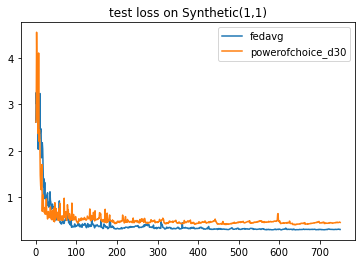

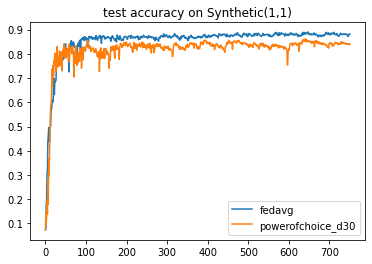

In [7]:
import flgo.experiment.analyzer
analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg', 'powerofchoice']
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'test_loss'}, 'fig_option':{'title':'test loss on Synthetic(1,1)'}},
            {'args':{'x': 'communication_round', 'y':'test_accuracy'},  'fig_option':{'title':'test accuracy on Synthetic(1,1)'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_plan)